### Description

According the source of data, data contains information about bankrupcy of Polish Companies. Purpose of this project is making the prediction of company bankrupcy. Dataset was taken from Kaggle Competition what can be find on adress:

https://www.kaggle.com/competitions/company-bankruptcy-prediction/overview

Quoting the source of dataset:

'The data was collected from Emerging Markets Information Service, which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.'

But why this topic ? Companies bankrupcy prediction is very important topic for modern economy. Many of interest groups are interested about those predictions. For example it could be crucial for banks and other financial institutions for decision of giving loan for the company or not. Also other groups can be interested about predictions of companies brankrupcy.It could be investors, customers, employers, governments. Good predictions can give them good awareness for future buissnes decisions.

Project will contain 11 sections. First two of them are technical but crucial to work on this dataset. There are:

1. Importing libaries
2. Defining functions
3. Data understanding
4. Data preparation 
5. Train models
6. Testing oversampling and undersampling techniques
7. Hyperparameter tuning
8. Feature importances
9. Finding best treshold
10. Final thoughts about best mode
11. Conclusion

For modeling here is used just train.csv dataset, got from originally cource.

### 1. Importing libaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import recall_score, precision_recall_curve, auc, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import warnings 

### 2. Defining functions and classes

In [2]:
def data_converter(df):
    """ Converting columns which incluede numerical values to float, and categorical to One Hot Encoding.
    
        Args: DataFrame
    
        Return: Converted DataFrame."""
    
    for column in df.columns:
        if df[column].dtypes == 'int64':
            continue
        else:
            df[column] = df[column].astype('float64')
            
    return df

In [3]:
def percentage_of_nans(df):
    """ Find size of nan values in each column.
    
        Args: DataFrame 
    
        Return: Percentage of nan values. """
    
    percentage = ((df.isna().sum() / df.shape[0])*100).round(2)
    
    return percentage

In [4]:
def drop_nan_columns(df, perc=0.1):
    """ Drop columns where size of nan values is above perc value.
    
        Args: DataFrame, perc 
    
        Return: DataFrame with dropped columns."""
    
    columns_to_drop = list(df.columns[np.where(df.isna().sum() > perc * df.shape[0])])
    df = df.drop(columns_to_drop, axis=1)
    
    return df   

In [5]:
def outlier_clipper(df, first_q=25, third_q=75):
    ''' Funtion which is detecting outliers and chainging them into values 
        more similar to other values. Function is using Inter Quartile Range,
        and outliers are chainged into values equal to substraction of IQR multiplicated by
        1.5 from first quartile, when they are lower than most values, and sum of IQR and
        third quartile if they're higher. Values first_q and third_q can be chainged.
        
        Args: DataFrame, first_q, third_1
        
        Return: DataFrame without outliers '''
        
    for column in df.columns:
        q2,q1 = np.nanpercentile(df[column],[third_q,first_q])
        intr_qr = q2-q1
 
        maximum = q2+(1.5*intr_qr)
        minimum = q1-(1.5*intr_qr)
 
        df[column] = df[column].clip(minimum, maximum)
    return df

### 3. Data understanding

Let's start from importing train dataset.

In [6]:
df = pd.read_csv('train.csv', index_col='id') # column 'id' is not valuable for calculations

C:\Users\amade\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,6,7,8,10,11,12,15,16,19,23,26,30,36,37,39,49,52,56,58,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Many of columns contains sign '?' what can be explained as missing values. Those values should be converted into nans.

In [7]:
df.replace('?', np.nan, inplace=True) # values '?' were tested earlier, showing that is not valuable for project

Checking shape of Data Frame:

In [8]:
df.shape

(25121, 66)

Data frame is build from 66 columns and 25121 rows. In the next step let's look at the columns, and what data type they contain.

In [9]:
df.dtypes.head(33) # view of first 33 columns

forecasting period                                                                                                                     int64
net_profit_over_total_assets                                                                                                          object
total_liabilities_over_total_assets                                                                                                   object
working_capital_over_total_assets                                                                                                     object
current_assets_over_short_term_liabilities                                                                                            object
cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365    object
retained_earnings_over_total_assets                                                                                                   object
EBIT_over_tot

In [10]:
df.dtypes.tail(33) # view of last 33 columns

operating_expenses_over_short_term_liabilities                                                                  object
operating_expenses_over_total_liabilities                                                                       object
profit_on_sales_over_total_assets                                                                               object
total_sales_over_total_assets                                                                                   object
current_assets_minus_inventories_over_long_term_liabilities                                                     object
constant_capital_over_total_assets                                                                              object
profit_on_sales_over_sales                                                                                      object
current_assets_minus_inventory_minus_receivables_over_short_term_liabilities                                    object
total_liabilities_over_profit_on_operating_activ

Most of columns there are 'object' data type. Only two columns are int64. Look at the values which they contain:

In [11]:
df['forecasting period'].unique()

array([4, 1, 2, 3], dtype=int64)

In [12]:
df['class'].unique()

array([1, 0], dtype=int64)

There are not many values in both classes. Both of them can be understood as a columns which contain categorical values. According the source of dataset values in 'class' column can be explained as:

- '1' - bankrupcy of the company
- '0' - company didn't bankrupt in analized period

This column will be used as a goal for predictions in trained models.

Take a look at distribution of both columns. Let's start from 'forecasting period'

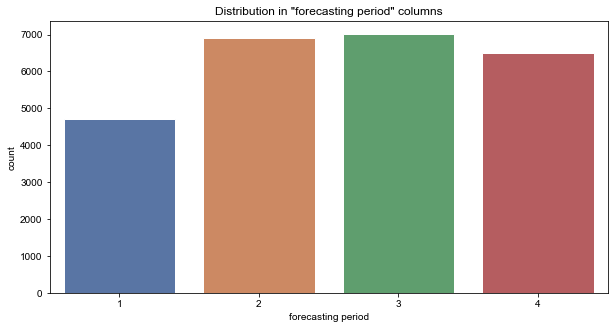

In [13]:
plt.figure(figsize=(10,5))
plt.title('Distribution in "forecasting period" columns')
sns.set_theme(style="darkgrid")
sns.countplot(data=df, x='forecasting period')
plt.show()

And most important, 'class':

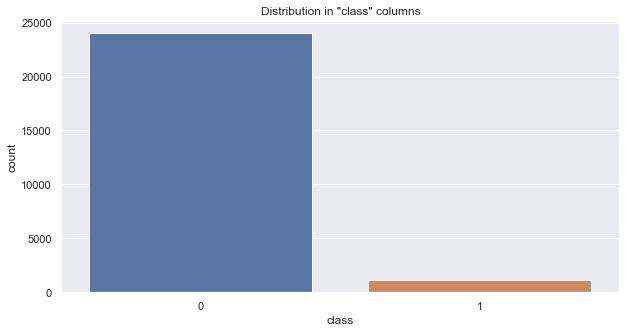

In [14]:
plt.figure(figsize=(10,5))
plt.title('Distribution in "class" columns')
sns.set_theme(style="darkgrid")
sns.countplot(data=df, x='class')
plt.show()

As it can be seen dataset is **highly imbalanced**. This is the crucial information how to work with dataset. For choosing best model will be used f-1 score instead accuracy. Also it is crucial form methods which will be used.

Take a look at percentage of class '1':

In [15]:
print('Distribution of classes:')
df['class'].value_counts(normalize=True).round(2)

Distribution of classes:


0    0.96
1    0.04
Name: class, dtype: float64

Bancrupted companies are only 4 % of whole dataset!

Becouse it is needed to make calculations on data columns which contain 'object' data type should be tranfsormed into floats. To make it, it will be used function which was defined earlier. 

In [16]:
df = data_converter(df)  # 'object' columns can't be used in pd.DataFrame.describe() method

Take a look at description of chainged data:

In [17]:
df.describe().T.head(33)

,count,mean,std,min,25%,50%,75%,max
forecasting period,25121.0,2.608574,1.063099,1.000000e+00,2.000000,3.000000,4.000000,4.000000e+00
net_profit_over_total_assets,25118.0,0.046883,1.821696,-2.568900e+02,0.003354,0.049864,0.131419,5.265200e+01
total_liabilities_over_total_assets,25118.0,0.611913,5.933447,-7.216201e+01,0.271005,0.476965,0.693583,4.809600e+02
working_capital_over_total_assets,25118.0,0.098553,5.908136,-4.799600e+02,0.016605,0.191679,0.401751,2.276900e+01
current_assets_over_short_term_liabilities,25043.0,6.285753,339.973627,-4.485087e-02,1.037774,1.553757,2.767430,5.343300e+04
cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,25064.0,-91.259359,18284.760673,-1.670200e+06,-50.587483,-1.702077,51.206270,1.034100e+06
retained_earnings_over_total_assets,25118.0,-0.067728,6.873121,-5.084100e+02,-0.000010,0.000003,0.085018,3.222000e+02
EBIT_over_total_assets,25118.0,0.147535,5.835287,-1.895600e+02,0.005649,0.060077,0.153186,6.492300e+02
book_value_of_equity_over_total_liabilities,25072.0,15.153162,611.473437,-1.414102e+02,0.422289,1.051214,2.593104,5.343200e+04
sales_over_total_assets,25114.0,2.905686,74.384884,-1.215686e+00,1.019551,1.213246,2.112687,9.742300e+03


In [18]:
df.describe().T.tail(33)

,count,mean,std,min,25%,50%,75%,max
operating_expenses_over_short_term_liabilities,25043.0,9.145943,147.602412,-1.919698e+01,2.828204,4.627528,7.862351,2.194400e+04
operating_expenses_over_total_liabilities,25072.0,5.938933,150.355074,-1.696000e+03,0.327897,2.030332,4.673940,2.194400e+04
profit_on_sales_over_total_assets,25118.0,0.154079,5.486899,-6.145501e+01,0.005758,0.060118,0.152671,6.269200e+02
total_sales_over_total_assets,25118.0,3.137966,74.236608,-8.626059e-04,1.106802,1.662492,2.458801,9.742300e+03
current_assets_minus_inventories_over_long_term_liabilities,13968.0,119.562471,3891.520763,-5.255159e+02,1.104154,3.017924,10.760262,3.989200e+05
constant_capital_over_total_assets,25118.0,0.707527,14.584634,-4.799100e+02,0.417139,0.609892,0.771124,1.099500e+03
profit_on_sales_over_sales,25044.0,-0.488882,49.296016,-7.522000e+03,0.003969,0.036436,0.091479,2.931500e+02
current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,25043.0,1.848230,29.388666,-1.254503e+01,0.052874,0.174622,0.645893,2.883000e+03
total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,24664.0,0.861321,31.852478,-1.086801e+03,0.025975,0.084493,0.205739,3.443404e+03
profit_on_operating_activities_over_sales,25044.0,-0.245407,14.628531,-1.395800e+03,0.000019,0.037738,0.091912,1.659500e+02


First conclusion what can be seen from destription is diffrences in counts. It can be explained, becouse method 'df.describe()' dont't make calculations on missing values, so missing values are not included to counting.
Let's look at missing values distribution of each column. Here wil be used function 'percentage_of_nans'.

In [19]:
perc_of_nans = percentage_of_nans(df)

In [20]:
warnings.filterwarnings("ignore") # ignore warning to clear the view

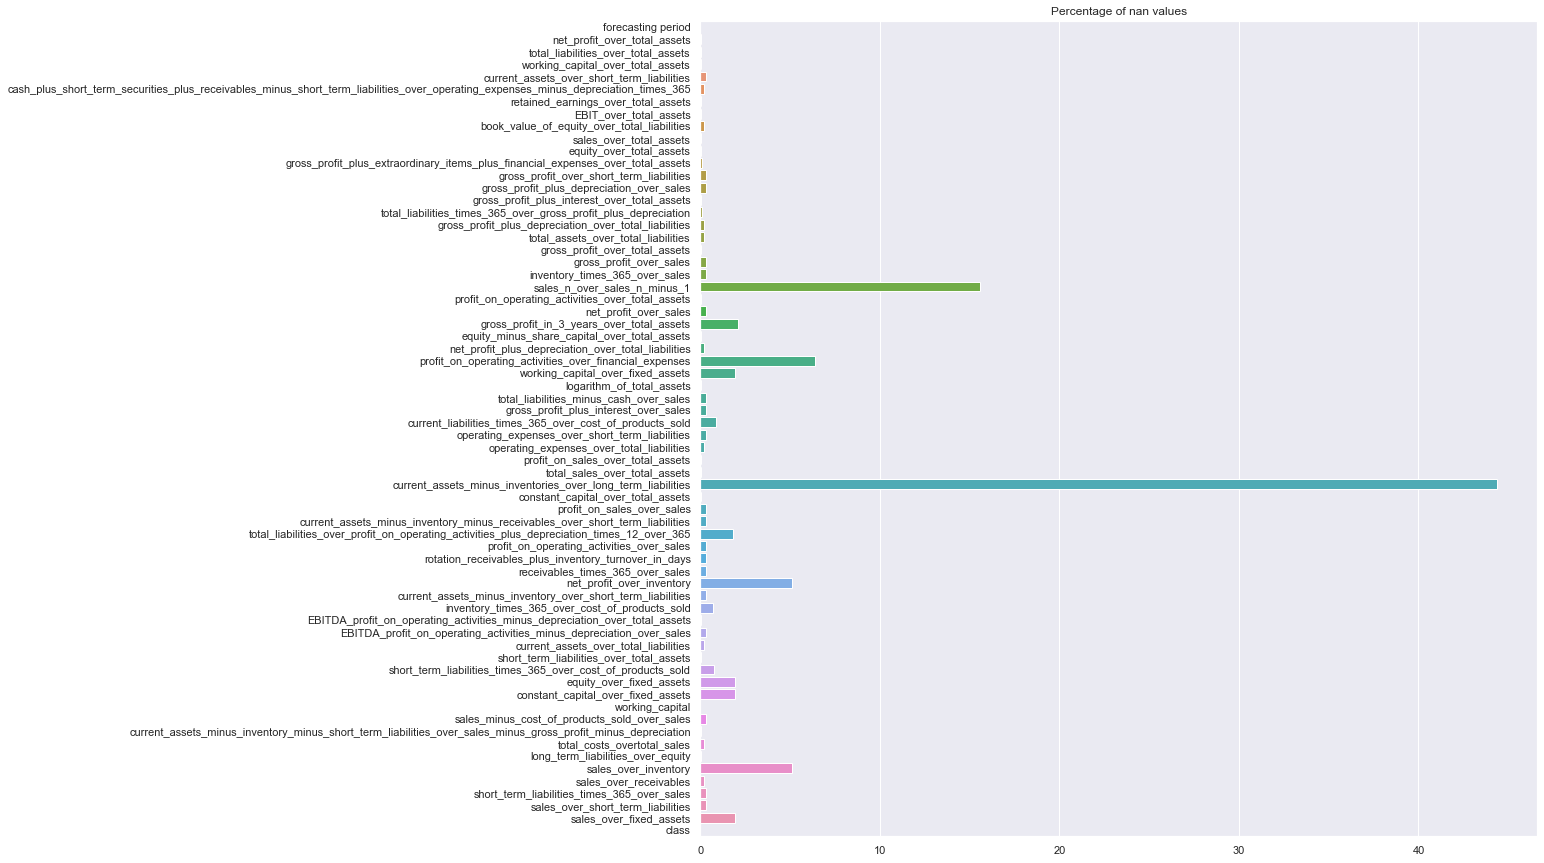

In [21]:
plt.figure(figsize=(15,15))
plt.title('Percentage of nan values')
sns.set_theme(style="darkgrid")
sns.barplot(perc_of_nans, perc_of_nans.index)
plt.show()

As it can be seen some of the columns contains many of missing values. Some of them will be useless for training a model.

In [22]:
perc_of_nans.where(perc_of_nans > 10).dropna() # looking for columns with percentage of nans above 10 %

sales_n_over_sales_n_minus_1                                   15.57
current_assets_minus_inventories_over_long_term_liabilities    44.40
dtype: float64

Two of them contains more than 10% of missing values: 'sales_n_over_sales_n_minus_1' and 'current_assets_minus_inventories_over_long_term_liabilities'. Second of them contains 44.4 % missing values. It is almost
half of dataset!

Also 15.57 % is a big part of whole dataset. For both of these columns imputing some artificial values can disturb future results.

Second concluion according the data description is fact that where are values which are highly diffrent than median or first and second quertille (min and max columns). Let's look at the boxplots to understand this fact:

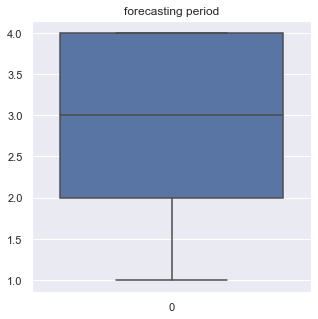

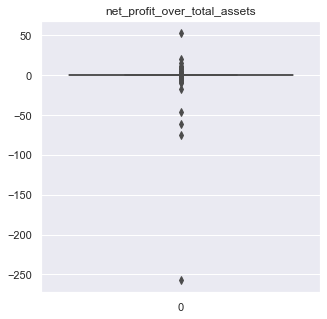

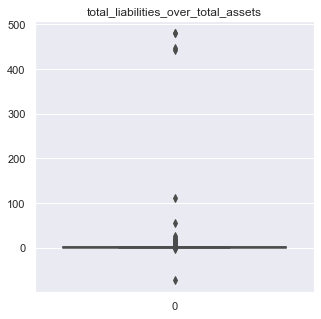

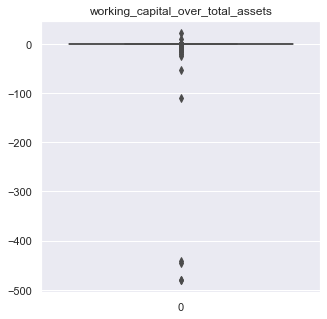

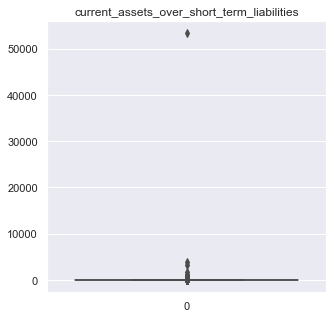

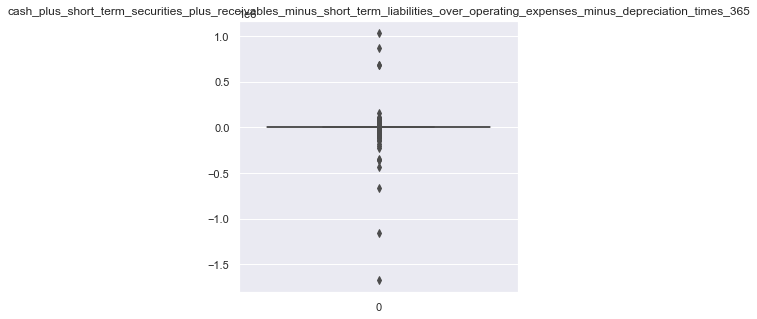

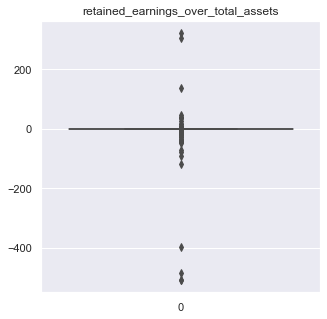

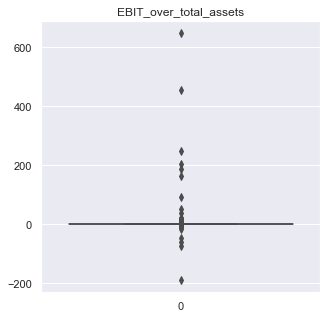

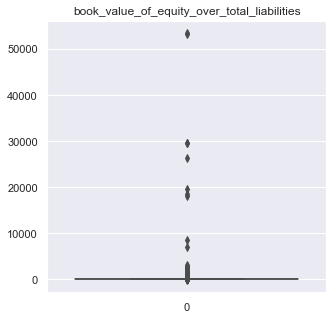

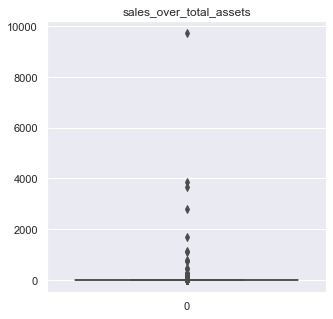

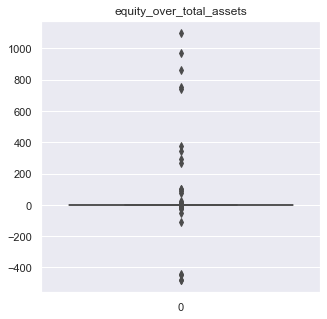

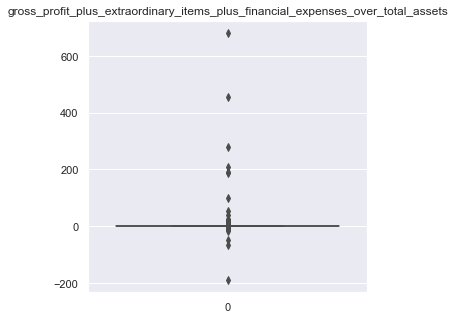

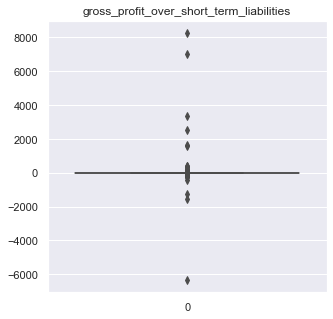

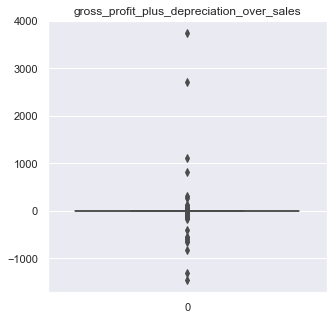

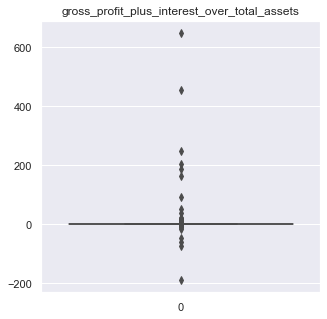

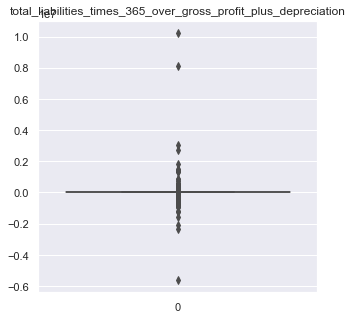

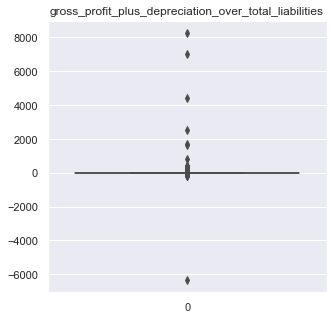

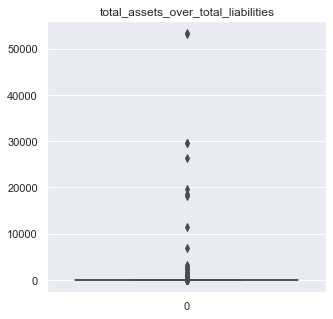

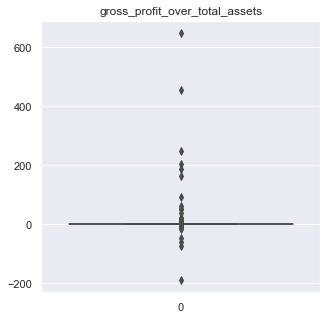

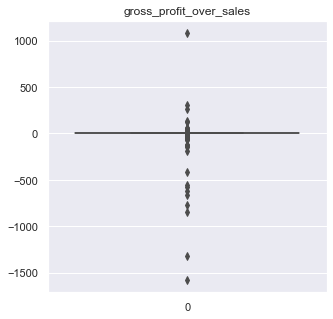

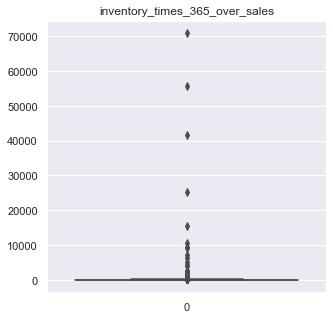

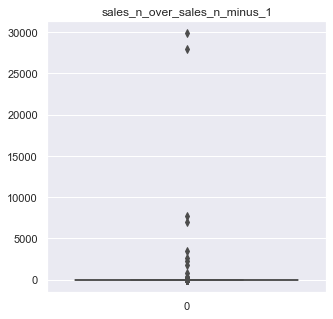

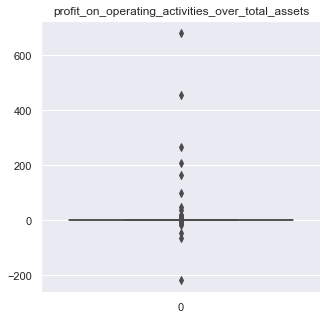

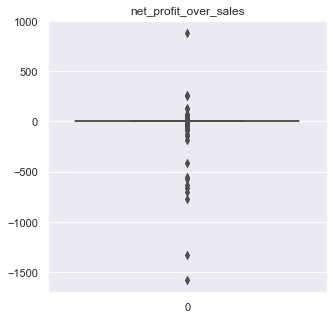

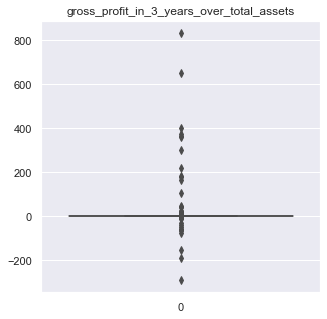

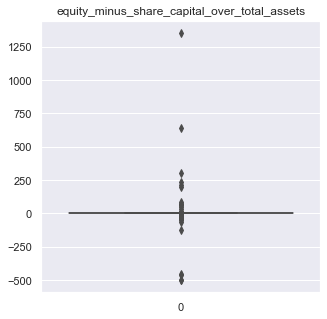

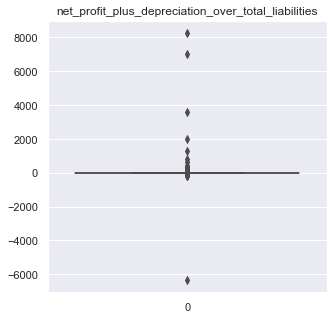

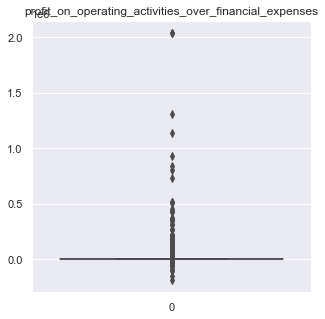

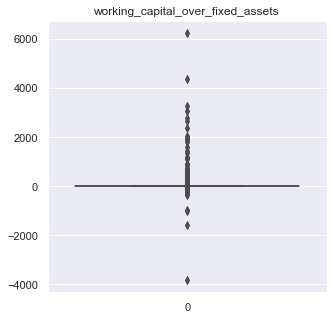

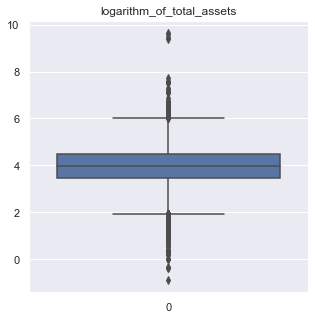

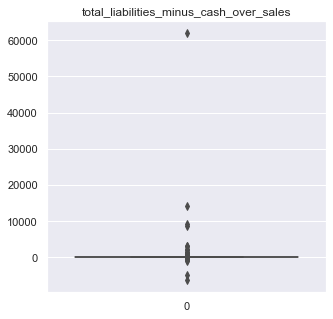

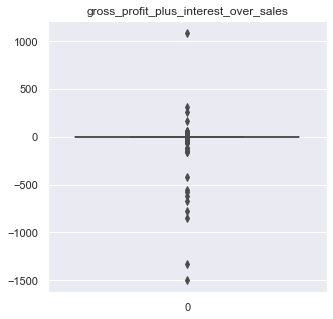

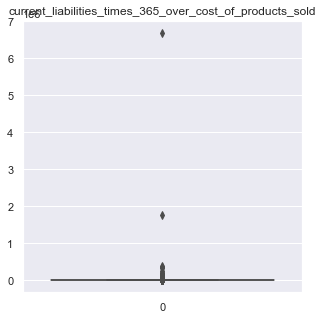

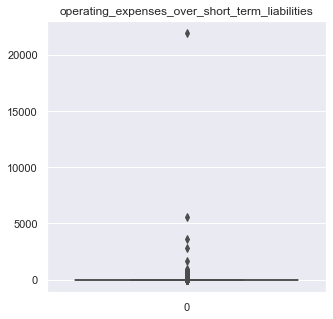

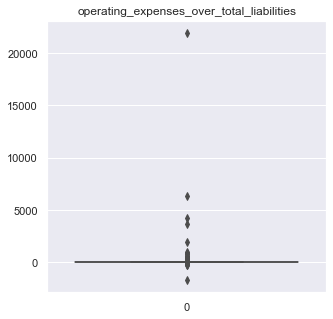

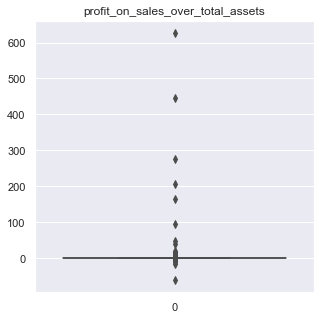

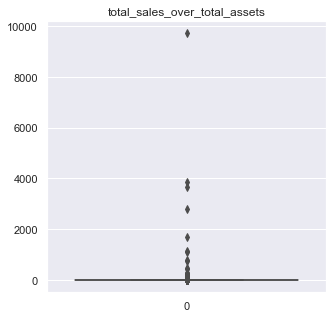

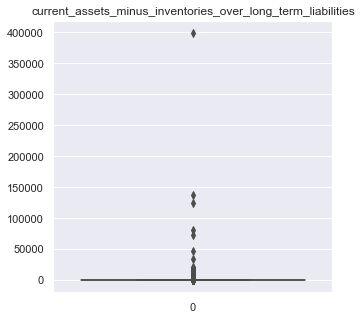

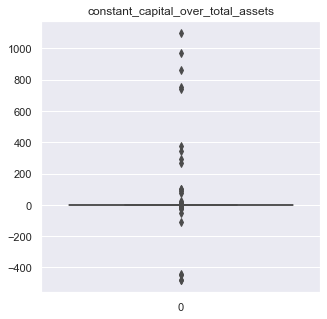

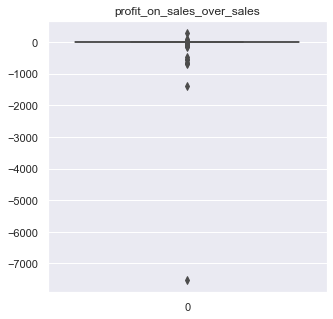

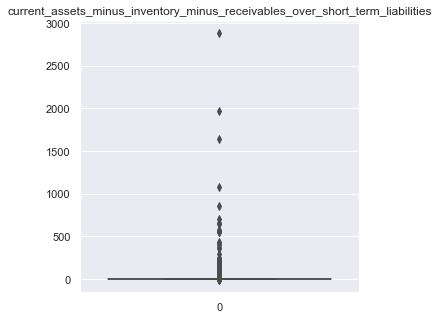

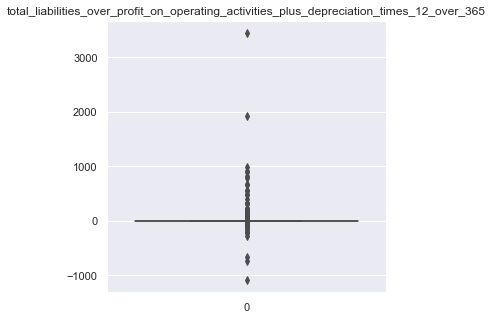

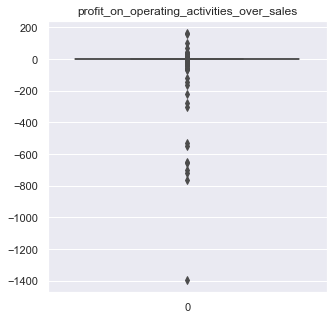

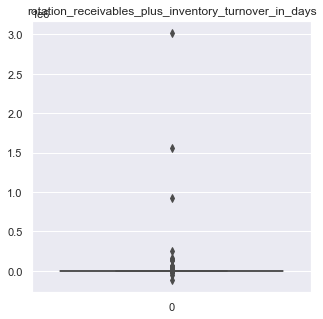

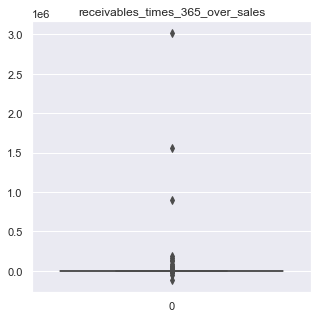

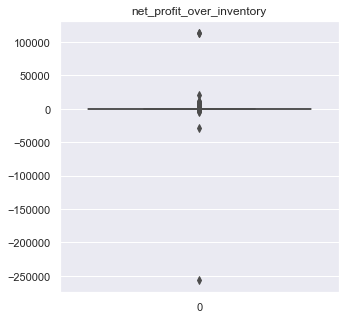

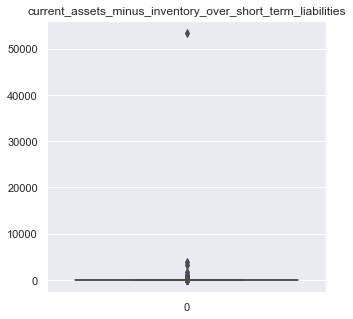

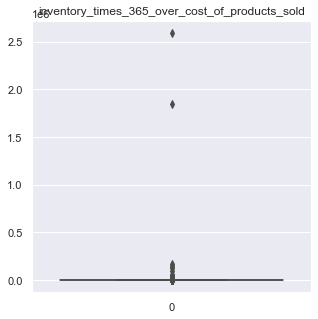

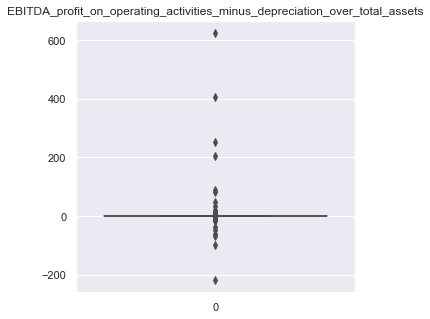

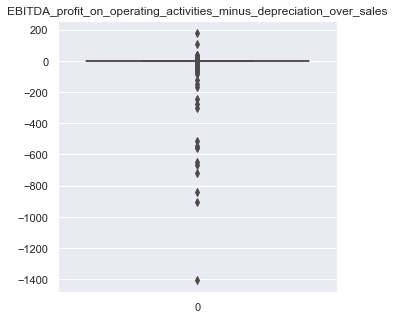

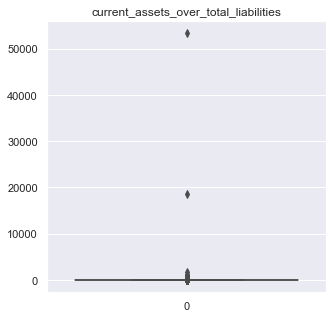

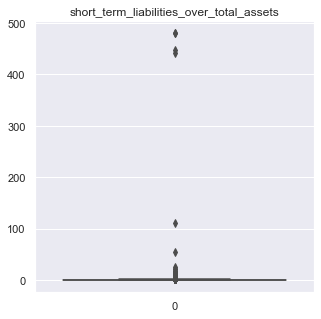

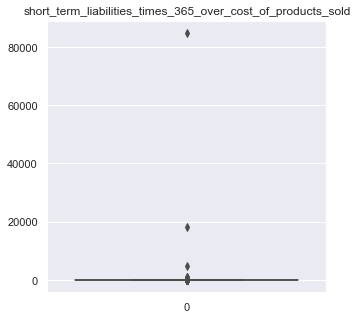

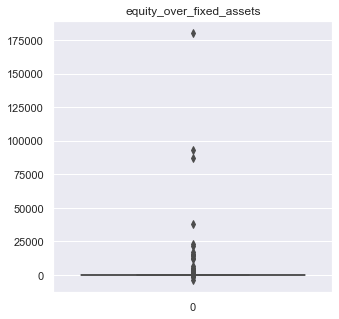

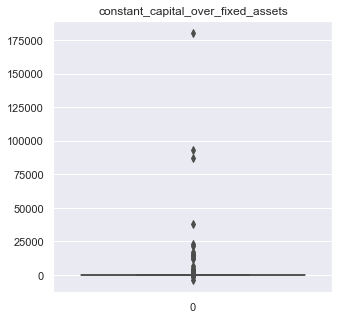

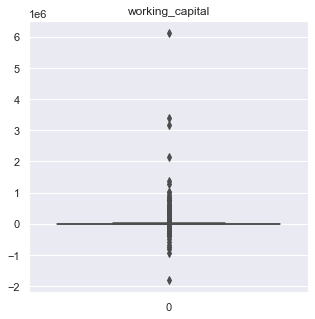

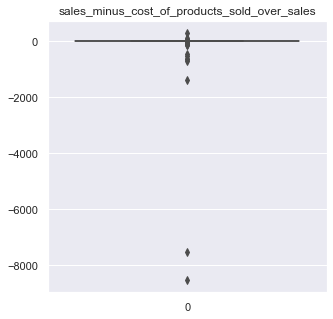

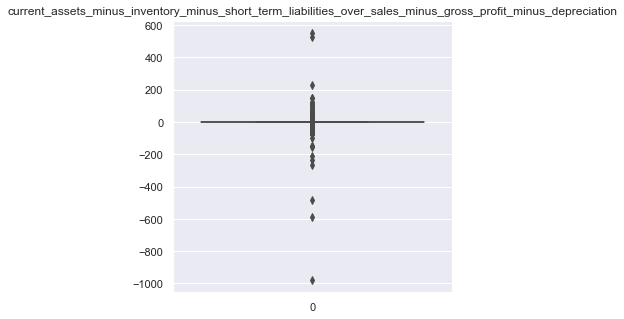

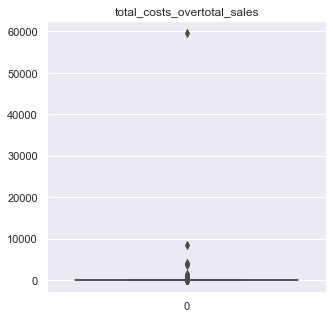

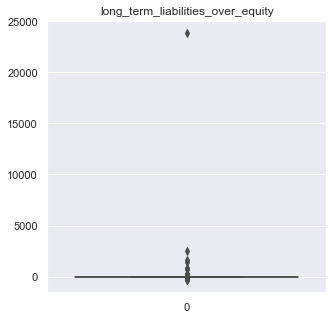

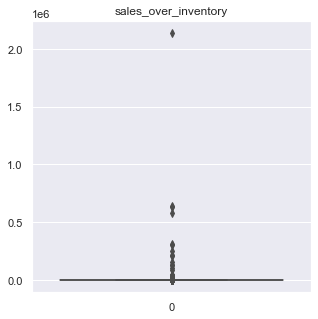

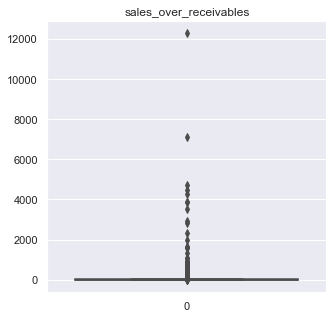

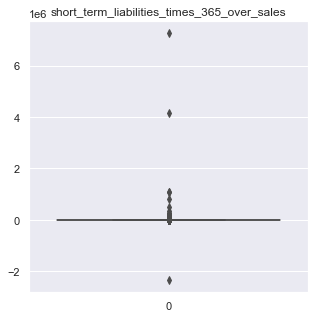

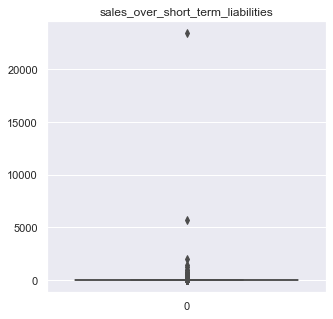

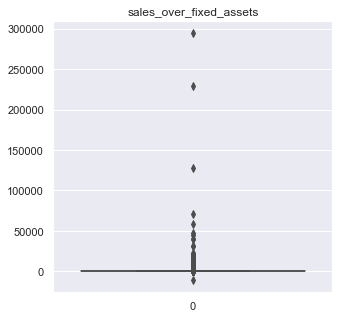

In [23]:
for column in df.columns[:-1]:
    plt.figure(figsize=(5,5))
    plt.title(str(column))
    sns.set_theme(style="darkgrid")
    sns.boxplot(data=df[column])
    plt.show()

As is it shown in the boxplots there are many outliers which are highly diffrent than most of data in dataset. They can have high influence to the results. 

### 4. Data preparation

Here data will be prepared to train models.

Let's start from splitting dataset into X - data, y - predicted class.

In [24]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:] # 'class' column

One of the most important issues is dealing with columns which contain too much of missing values. As it was shown it previous chapter, some of columns contain more than 10% missing values. Probably those columns request nothing important into results.
Columns will be dropped using function.

In [25]:
X = drop_nan_columns(X)

Let's take a look at results:

In [26]:
X.head()

,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,...,working_capital,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets
id,,,,,,,,,,,,,,,,,,,,,
0,4,0.141939,0.450292,0.021422,1.052987,-28.529084,0.141934,0.172629,0.990337,1.087356,...,800.542408,0.079572,0.318286,0.927687,0.106818,12.941797,10.044585,64.713700,5.626894,3.937064
1,4,0.147560,0.234840,0.708335,4.016018,119.445611,0.457090,0.186070,3.206445,1.093404,...,24093.000493,0.095218,0.195943,0.907056,-0.000029,233.301688,2.747416,36.967435,9.813419,40.567739
2,1,-0.024542,0.311544,0.067831,1.255247,-15.019923,-0.657003,-0.024537,2.209000,0.825578,...,851.179200,0.109035,-0.035634,0.929825,0.055331,8.589991,5.164738,117.924040,3.098273,1.239711
3,2,0.159317,0.777017,0.207431,1.267310,-4.892918,-0.000005,0.159321,0.288177,2.283532,...,2577.614840,0.102971,0.714528,0.937895,-0.000077,9.928221,5.912786,123.752610,2.946008,130.208321
4,4,0.004404,0.577419,-0.104435,0.786225,-116.911618,0.056561,0.004249,0.692166,1.013605,...,-11887.079853,0.016446,0.011019,0.979425,0.221335,5.099541,6.890130,166.761980,2.189705,1.740353


In [27]:
X.shape

(25121, 63)

As we can see two of those columns were dropped.

Last issue is what to do with outliers. As it was explained previously they have high influence into data. They are highly diffrent than rest of data, but size of them disturbs metrics like mean or standard deviation, so many types of normalizers will not work propely with those data. For some models few single highly diffrent values will also be a barrier.

However some of those values can be crucial for predictions, so they should't be delated. So how to deal with them ?

In this notebook there was used detecting of outliers using Inter Quartile Range. This method is calculating range between first quartile and third quartile. Result is multiplied by 1.5 and this value is added to third quartile, and all values which are higher that this sum, are threated as outliers. The same result of multiplication is substracted from first quartile, and values which are less than this restult also are outliers.

But what next? What to do with values which are outliers? Becouse they can be valuable it is not good to delate them. This notebook is using clip method from numpy libary. Everything is written in function 'outlier_clipper'.

Let's look at the effects of trasformation:

In [28]:
X.describe()

,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,...,working_capital,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets
count,25121.000000,25118.000000,25118.000000,25118.000000,25043.000000,2.506400e+04,25118.000000,25118.000000,25072.000000,25114.000000,...,2.512000e+04,25044.000000,25118.000000,25068.000000,25118.000000,2.383900e+04,25064.000000,2.504400e+04,25043.000000,24630.000000
mean,2.608574,0.046883,0.611913,0.098553,6.285753,-9.125936e+01,-0.067728,0.147535,15.153162,2.905686,...,6.941829e+03,-0.770713,0.098693,4.429418,1.597135,3.225273e+02,14.315634,7.394522e+02,9.835042,77.756289
std,1.063099,1.821696,5.933447,5.908136,339.973627,1.828476e+04,6.873121,5.835287,611.473437,74.384884,...,6.625093e+04,72.977149,10.380960,383.343937,152.441163,1.606698e+04,120.835222,5.627363e+04,154.676272,2694.281611
min,1.000000,-256.889998,-72.162006,-479.959994,-0.044851,-1.670200e+06,-508.409992,-189.559992,-141.410220,-1.215686,...,-1.805200e+06,-8534.599415,-979.250019,-1.631820,-327.970143,-4.066151e-02,-12.655400,-2.336500e+06,-0.367905,-10677.001615
25%,2.000000,0.003354,0.271005,0.016605,1.037774,-5.058748e+01,-0.000010,0.005649,0.422289,1.019551,...,1.557841e+01,0.008843,0.015141,0.875577,-0.000002,5.620743e+00,4.538417,4.158029e+01,3.100047,2.185147
50%,3.000000,0.049864,0.476965,0.191679,1.553757,-1.702077e+00,0.000003,0.060077,1.051214,1.213246,...,9.814254e+02,0.052831,0.122515,0.950947,0.005193,9.973974e+00,6.732840,7.090939e+01,5.116548,4.340603
75%,4.000000,0.131419,0.693583,0.401751,2.767430,5.120627e+01,0.085018,0.153186,2.593104,2.112687,...,4.555318e+03,0.129194,0.293705,0.993072,0.241881,2.082144e+01,10.601720,1.169599e+02,8.708598,9.892896
max,4.000000,52.651999,480.960001,22.769001,53433.000440,1.034100e+06,322.199997,649.230003,53431.999474,9742.300107,...,6.123700e+06,293.158392,552.639985,59671.999668,23853.000122,2.137800e+06,12296.000520,7.276000e+06,23453.999855,294769.993913


In [29]:
X = outlier_clipper(X) 

In [30]:
X.describe() # to see difrences

,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,...,working_capital,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets
count,25121.000000,25118.000000,25118.000000,25118.000000,25043.000000,25064.000000,25118.000000,25118.000000,25072.000000,25114.000000,...,25120.000000,25044.000000,25118.000000,25068.000000,25118.000000,23839.000000,25064.000000,25044.000000,25043.000000,24630.000000
mean,2.608574,0.064789,0.502245,0.201917,2.117495,0.580663,0.030858,0.077711,1.800524,1.622355,...,2472.508672,0.071024,0.156895,0.932305,0.139954,15.409199,8.266768,87.430446,6.544984,7.237942
std,1.063099,0.123153,0.297582,0.302710,1.511079,102.080377,0.102778,0.139186,1.892026,0.924788,...,4645.672737,0.115969,0.268467,0.113188,0.234093,13.358664,5.195869,61.213919,4.673866,6.898892
min,1.000000,-0.188745,-0.362860,-0.561115,-0.044851,-203.278114,-0.127552,-0.215657,-2.833933,-0.620152,...,-6794.030654,-0.171683,-0.402706,0.699334,-0.362826,-0.040662,-4.556538,-71.489152,-0.367905,-9.376478
25%,2.000000,0.003354,0.271005,0.016605,1.037774,-50.587483,-0.000010,0.005649,0.422289,1.019551,...,15.578405,0.008843,0.015141,0.875577,-0.000002,5.620743,4.538417,41.580286,3.100047,2.185147
50%,3.000000,0.049864,0.476965,0.191679,1.553757,-1.702077,0.000003,0.060077,1.051214,1.213246,...,981.425438,0.052831,0.122515,0.950947,0.005193,9.973974,6.732840,70.909391,5.116548,4.340603
75%,4.000000,0.131419,0.693583,0.401751,2.767430,51.206270,0.085018,0.153186,2.593104,2.112687,...,4555.317778,0.129194,0.293705,0.993072,0.241881,20.821445,10.601720,116.959912,8.708598,9.892896
max,4.000000,0.323518,1.327449,0.979471,5.361913,203.896900,0.212560,0.374492,5.849327,3.752390,...,11364.926838,0.309720,0.711552,1.169315,0.604705,43.622497,19.696676,230.029350,17.121425,21.454521


Let's look at the boxplots:

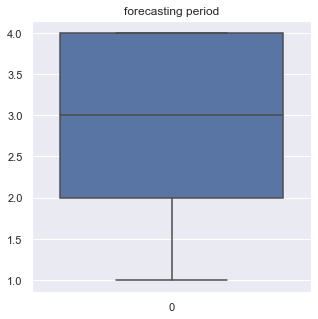

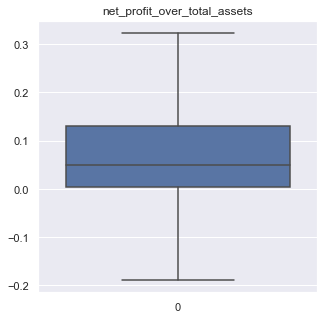

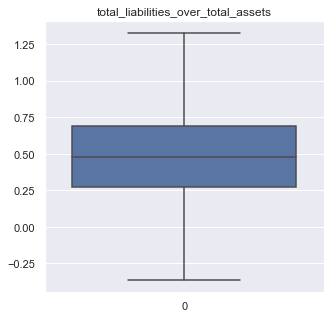

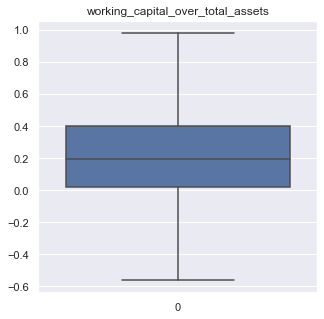

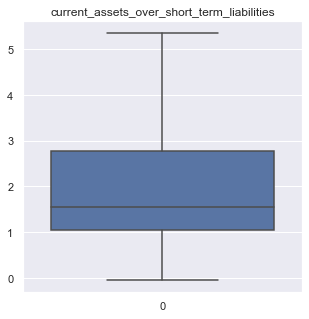

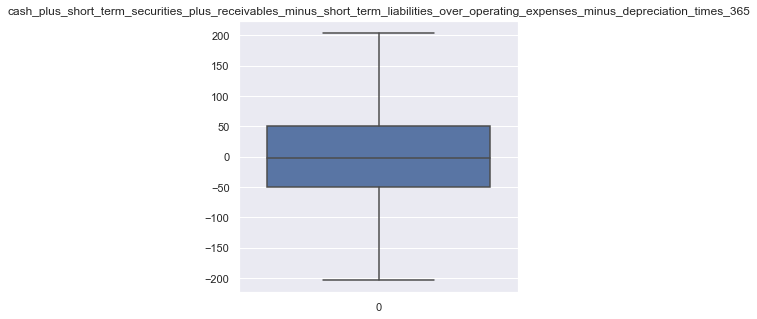

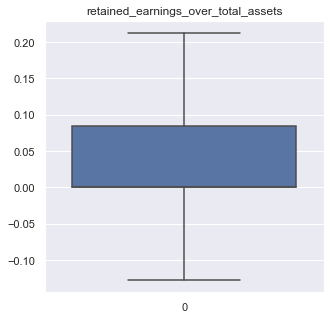

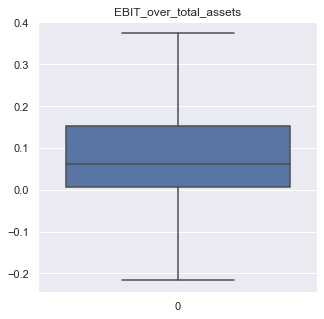

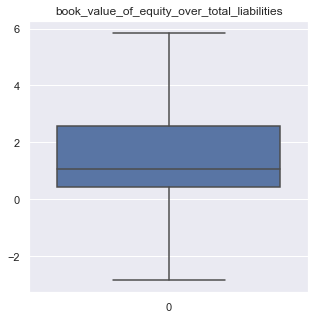

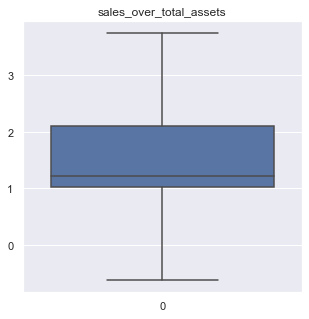

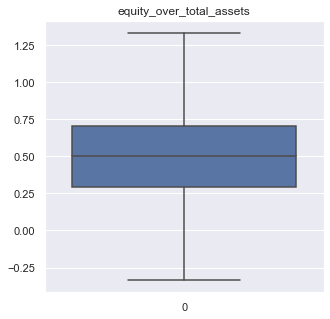

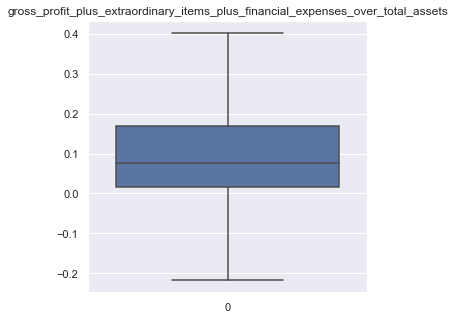

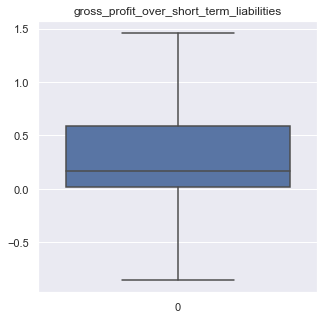

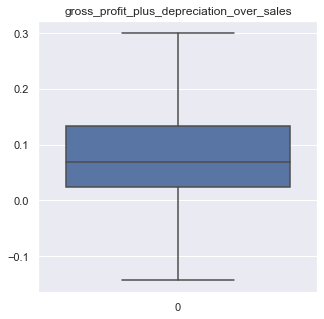

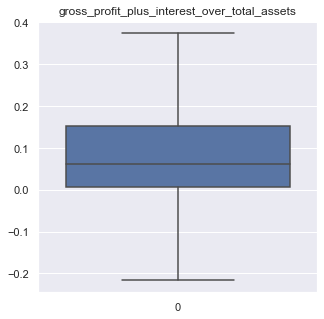

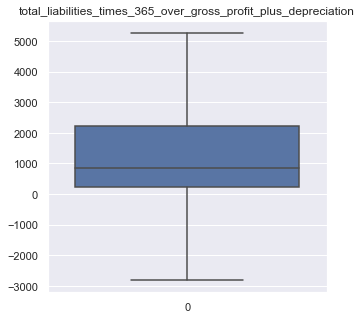

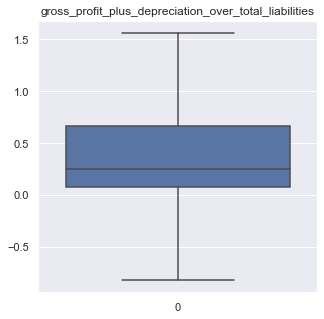

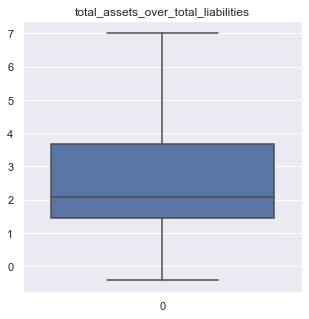

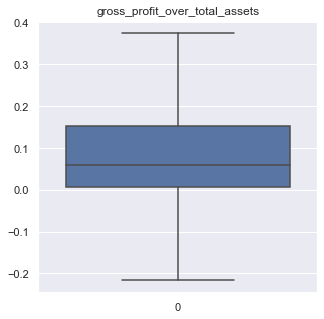

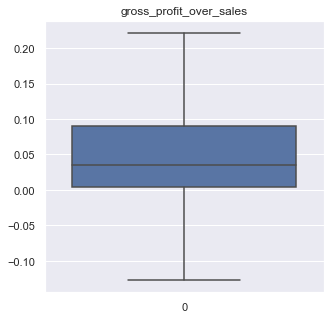

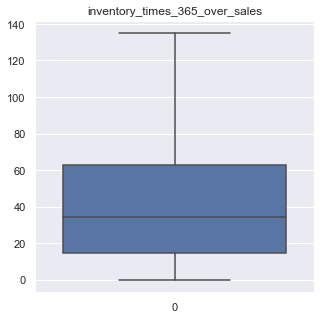

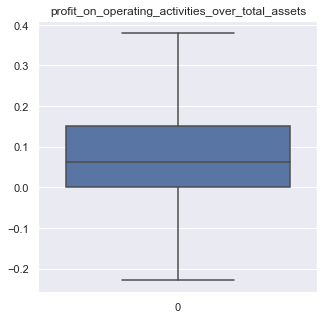

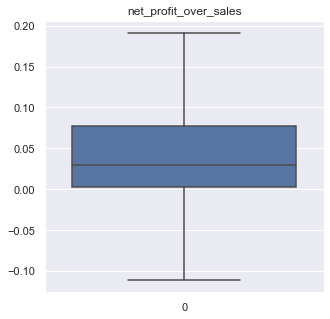

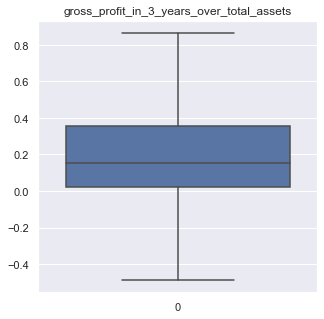

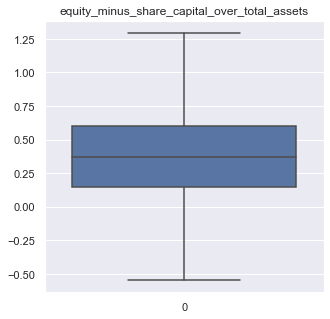

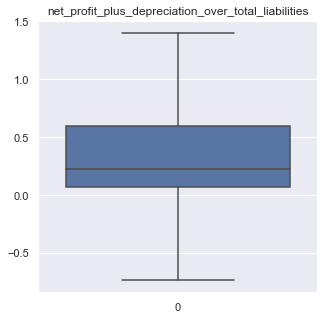

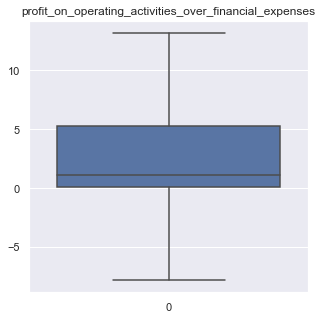

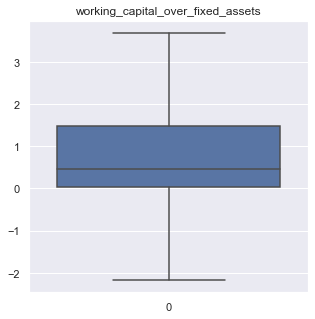

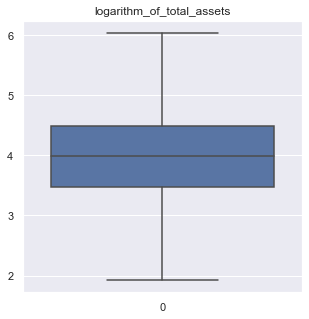

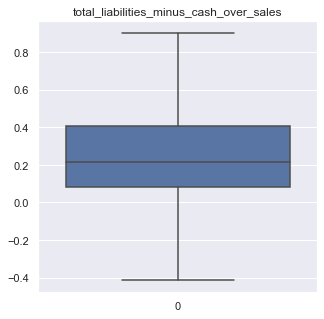

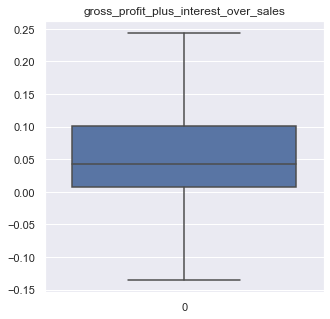

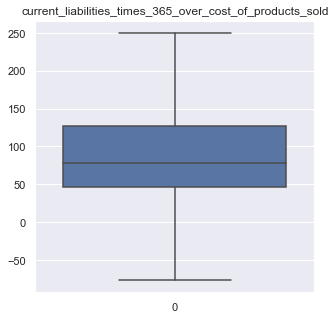

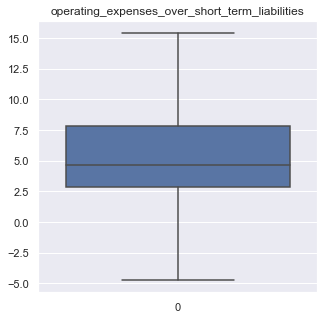

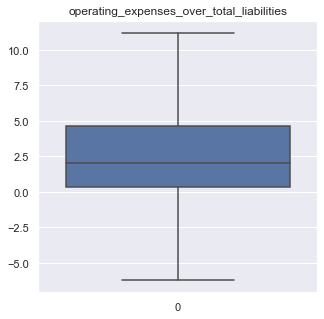

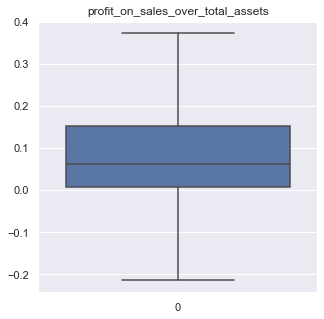

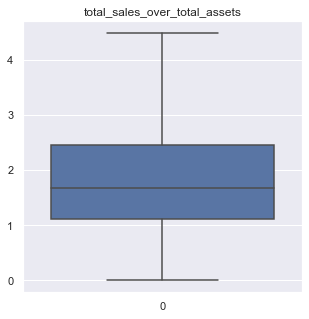

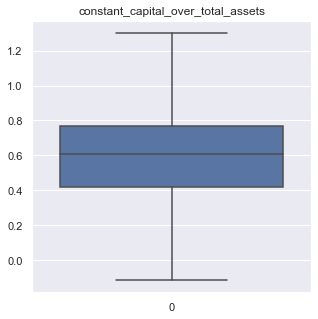

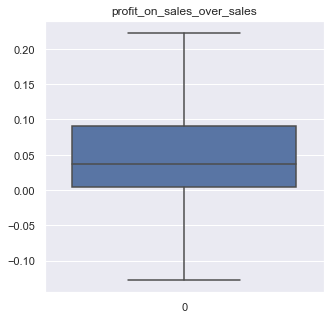

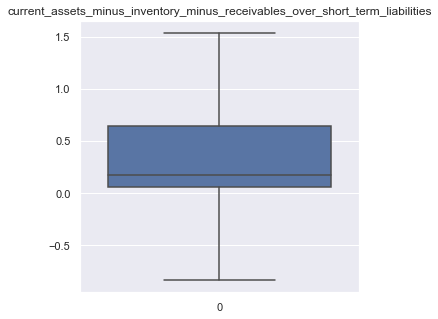

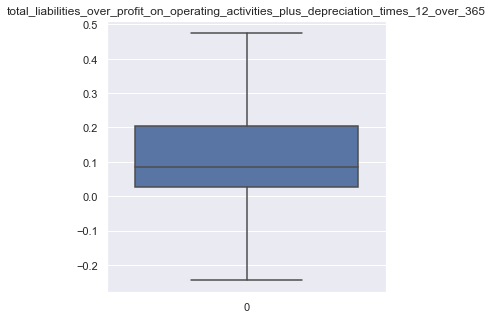

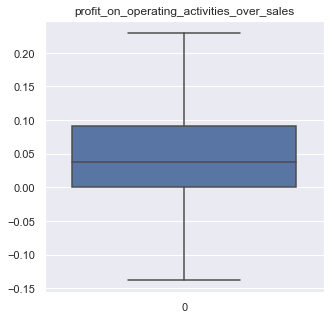

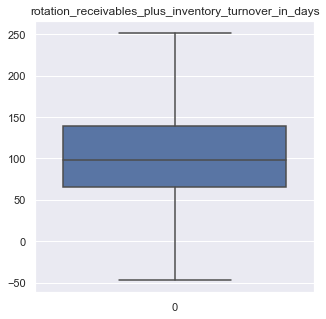

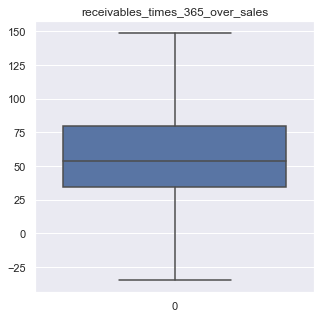

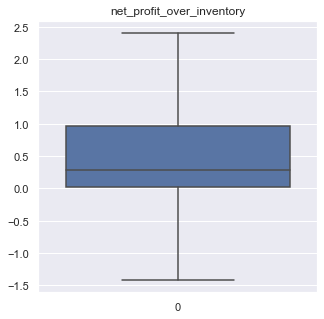

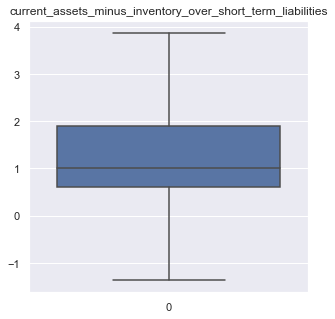

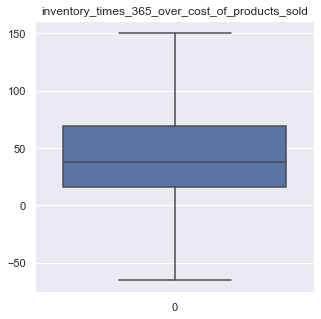

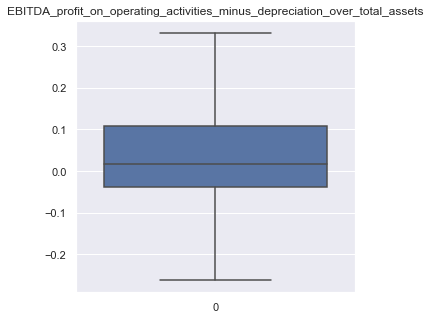

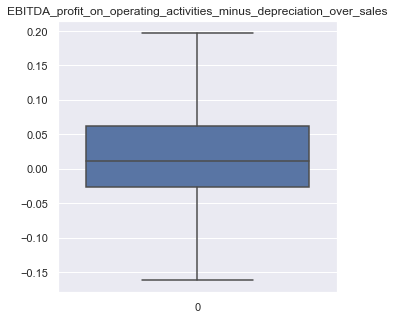

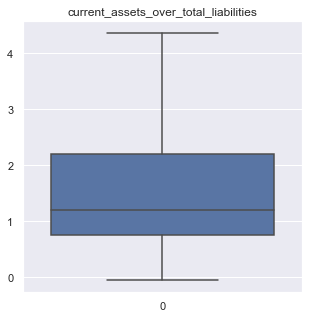

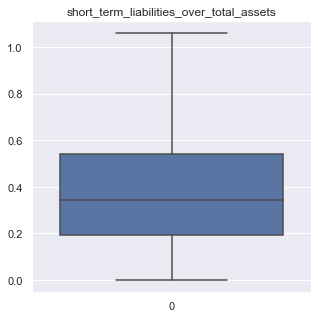

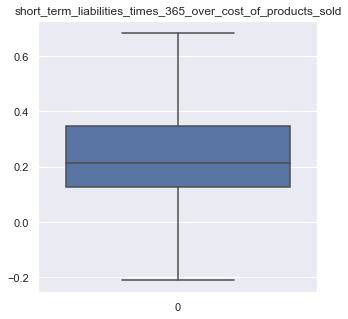

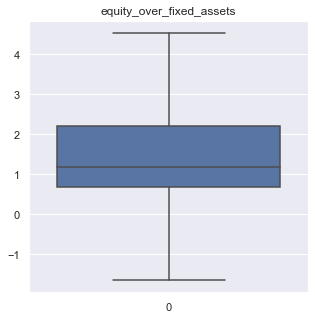

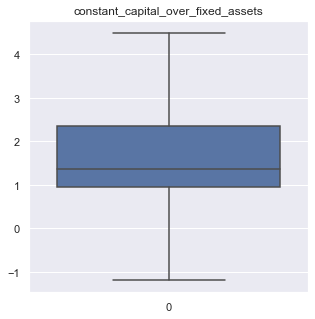

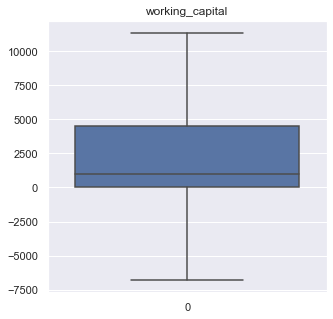

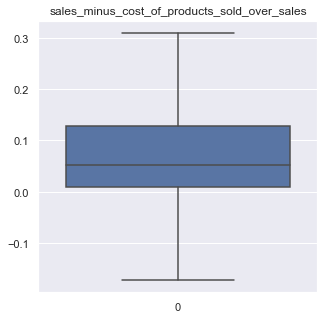

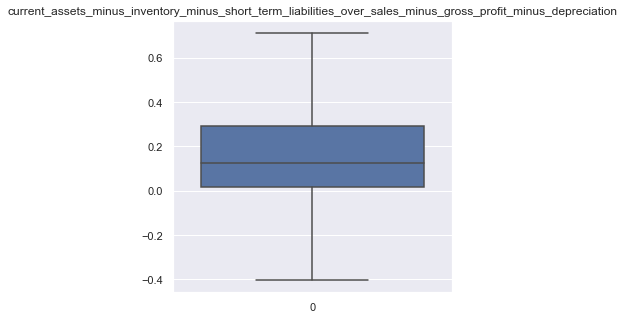

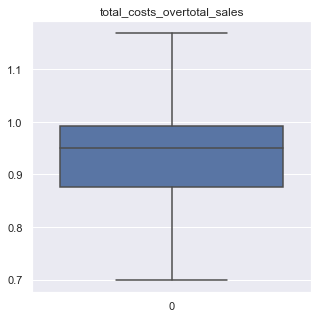

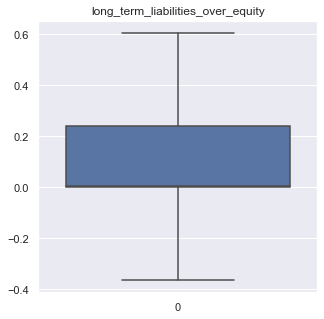

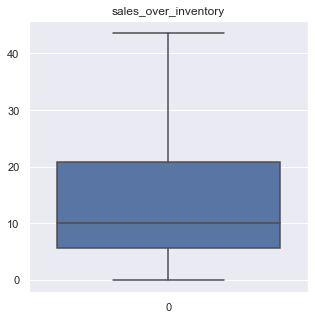

In [31]:
for column in X.columns[:-4]: # columns without 4 last columns, which are result of one hot encoding
    plt.figure(figsize=(5,5))
    plt.title(str(column))
    sns.set_theme(style="darkgrid")
    sns.boxplot(data=X[column])
    plt.show()

As it can be seen at boxplots, after transformation where are no outliers which can have influance for data.

Now it's time to train models!

### 5. Train models

**1. Split dataset into train set, and test. Define k-fold.**

In [32]:
# random_state = 42 to give the same results in diffrent devices
# test_size=0.3 - to have more class '1' rows in train set (dataset is imbalanced)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [33]:
k_fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True) # used later in GridSearchCV

**2. Choose model to fill nan values.**

There are diffrent methods used to fill nan values. In this section will be selected best model to input values into places where are missing values. Because dataset is still not normalized to this purpose will be used Decission Tree Classifier in default parameters. Why this model ? Tree models don't need to use normalized data. Without imputation models will not work. List of trained imputers:

- KNNImputer() - which is using K-Nearest Neighbours algorithm
- KNNImputer(weights='distance') - the same one, but is giving larger weight for neighbours which are nearer
- SimpleImputer() - imputs mean of columns
- SimpleImputer(strategy='median') - imputs median
- SimpleImputer(strategy='constant', fill_value=-5) - imputs coanstant value '-5' into places where are missing data

Because data is highly imbalanced to check which model is the best, there will be used f-1 metric.

In [34]:
impute_models = [KNNImputer(), KNNImputer(weights='distance'), SimpleImputer(), SimpleImputer(strategy='median'), SimpleImputer(strategy='constant', fill_value=-5)]

In [35]:
for model in impute_models:
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    X_test_copy = X_test.copy()
    y_test_copy = y_test.copy()
    impute_pipeline = make_pipeline(model, DecisionTreeClassifier())
    impute_pipeline.fit(X_train_copy, y_train_copy)
    y_impute_pred = impute_pipeline.predict(X_test_copy)
    f1_impute = f1_score(y_test_copy, y_impute_pred).round(4)
    print(str(model) + ": " + str(f1_impute))

KNNImputer(): 0.2789
KNNImputer(weights='distance'): 0.251
SimpleImputer(): 0.4929
SimpleImputer(strategy='median'): 0.4622
SimpleImputer(fill_value=-5, strategy='constant'): 0.4526


As it can be seen the best imputing model is Simple Imputer with default value. This imputer is using 'mean' as the value for replacing gaps.

**3. Choose models to train**

In this section there will be chosen 3 best models to train them later with diffrent parameters. 

In [36]:
xgb = XGBClassifier(verbosity=0) # 'verbosity=0' to hide warnings
cat = CatBoostClassifier(verbose=False, eval_metric='F1', random_state=42) # 'verbosity=False' to hide warnings

In [37]:
models = {'LogisticRegression' : LogisticRegression(),
          'SVC' : SVC(),
          'DecisionTreeClassifier' : DecisionTreeClassifier(),
          'RandomForestClassifier' : RandomForestClassifier(random_state=42),
          'GaussianNB' : GaussianNB(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'CatBoostClassifier' : cat,
          'XGBClassifier' : xgb,
          'BaggingClassifier' : BaggingClassifier(random_state=42),
          'KNeighborsClassifier' : KNeighborsClassifier()}
imputer = SimpleImputer()

In [38]:
models_dict = {}  # create dict to show best scores in DataFrame later
for name, model in models.items():
    X_train_copy = X_train.copy()
    y_train_copy = y_train.copy()
    X_test_copy = X_test.copy()
    y_test_copy = y_test.copy()
    selection_pipeline = make_pipeline(imputer, model)
    selection_pipeline.fit(X_train_copy, y_train_copy)
    y_selection_pred = selection_pipeline.predict(X_test_copy)
    f1_selection = f1_score(y_test_copy, y_selection_pred).round(4)
    models_dict[name] = f1_selection

In [39]:
models_df = pd.DataFrame(models_dict, index=['f1_score']).T

In [40]:
models_df.sort_values('f1_score', ascending=False) # best models on high

,f1_score
CatBoostClassifier,0.6602
XGBClassifier,0.6301
BaggingClassifier,0.5135
DecisionTreeClassifier,0.4923
RandomForestClassifier,0.3206
AdaBoostClassifier,0.1981
GaussianNB,0.1528
KNeighborsClassifier,0.0324
LogisticRegression,0.0000
SVC,0.0000


As it was shown three best models are:

- CatBoostClassifier
- XGBClassifier
- BaggingClassifier

Let's check diffrent normalization methods and are they improving results.

**4. Choose normalization model + one hot encoding 'forecasting period' column**

This section will test diffrent normalization methods. Models chosen to check:

- StandardScaler()
- MinMaxScaler()
- RobustScaler()
- PowerTransformer()
    
Column 'forecasting period' is chainged to One Hot Encoding form.

In [41]:
normalization_models = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer()]

In [42]:
to_norm = list(range(1,63)) # columns except 'forecasting period'

    A. CatBoostClassifier

In [43]:
cat_normalize_dict = {}
for norm in normalization_models:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('norm', norm, to_norm)])
    cn_pipeline = make_pipeline(imputer, ct, cat)
    cn_pipeline.fit(X_train_copy, y_train_copy)
    y_cn_pred = cn_pipeline.predict(X_test_copy)
    f1_cn = f1_score(y_test_copy, y_cn_pred).round(4)
    cat_normalize_dict[str(norm)] = f1_cn

In [44]:
cat_df = pd.DataFrame(cat_normalize_dict, index=['f1_score']).T

In [45]:
cat_df.sort_values('f1_score', ascending=False)

,f1_score
PowerTransformer(),0.6744
StandardScaler(),0.6743
RobustScaler(),0.6718
MinMaxScaler(),0.6692


PowerTransformer is improving model by 1.4% !

    B. XGBClassifier

In [46]:
xgb_normalize_dict = {}
for norm in normalization_models:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('norm', norm, to_norm)])
    xn_pipeline = make_pipeline(imputer, ct, xgb)
    xn_pipeline.fit(X_train_copy, y_train_copy)
    y_xn_pred = xn_pipeline.predict(X_test_copy)
    f1_xn = f1_score(y_test_copy, y_xn_pred).round(4)
    xgb_normalize_dict[str(norm)] = f1_xn


In [47]:
xgb_df = pd.DataFrame(xgb_normalize_dict, index=['f1_score']).T

In [48]:
xgb_df.sort_values('f1_score', ascending=False)

,f1_score
MinMaxScaler(),0.6486
RobustScaler(),0.6474
StandardScaler(),0.6448
PowerTransformer(),0.6448


MinMaxScaler improving f1 score for XGBClassifier model by 1.8%. It's good result, so for future modeling will be used this type of normalizing method.

    C. BaggingClassifier

In [49]:
bag_normalize_dict = {}
for norm in normalization_models:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('norm', norm, to_norm)])
    bn_pipeline = make_pipeline(imputer, ct, BaggingClassifier())
    bn_pipeline.fit(X_train_copy, y_train_copy)
    y_bn_pred = bn_pipeline.predict(X_test_copy)
    f1_bn = f1_score(y_test_copy, y_bn_pred).round(4)
    bag_normalize_dict[str(norm)] = f1_bn


In [50]:
bag_df = pd.DataFrame(bag_normalize_dict, index=['f1_score']).T

In [51]:
bag_df.sort_values('f1_score', ascending=False)

,f1_score
PowerTransformer(),0.5391
MinMaxScaler(),0.5377
StandardScaler(),0.5237
RobustScaler(),0.4979


PowerTransformer is improving f-1 score in Bagging Classifier. But f-1 score a little bit above 50% ist still bad result. This model will be not used later.

### 6. Testing oversampling and undersampling techniques

In this section will be tested diffrent techniques of undersampling, undersampling, and mixed techniques. The reason to use that techniques is imbalanced dataset. Used packages:
- SMOTE
- BorderlineSMOTE
- SMOTETomek
- SMOTEENN
- NearMiss
- ADASYN

Let's take a look for a results!

**1. CatBoostClassifier**

In [52]:
pt = PowerTransformer() # define PowerTransformer - best normalization model for CatBoostClassifier

In [53]:
sampling_models = [SMOTE(random_state=42), BorderlineSMOTE(random_state=42), SMOTETomek(random_state=42), 
                   SMOTEENN(random_state=42), NearMiss(), ADASYN(random_state=42)]

In [54]:
cat_sampling_dict = {}
for sample in sampling_models:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('pt', pt, to_norm)])
    cs_pipeline = make_pipeline(imputer, ct, sample, cat)
    cs_pipeline.fit(X_train_copy, y_train_copy)
    y_cs_pred = cs_pipeline.predict(X_test_copy)
    f1_cs = f1_score(y_test_copy, y_cs_pred).round(4)
    cat_sampling_dict[str(sample)] = f1_cs

In [55]:
cat_df = pd.DataFrame(cat_sampling_dict, index=['f1_score']).T

In [56]:
cat_df.sort_values('f1_score', ascending=False)

,f1_score
ADASYN(random_state=42),0.7133
SMOTE(random_state=42),0.7077
SMOTETomek(random_state=42),0.6928
BorderlineSMOTE(random_state=42),0.6873
SMOTEENN(random_state=42),0.5923
NearMiss(),0.1146


ADASYN algorithm is improving f-1 score for CatBoostClassifier to 71.33 %. Let's check results with diffrent sampling strategies:

In [57]:
sample_strategies = np.linspace(0.1, 1, 9).round(1) # sampling strategies from 0.1 to 1, default is 1

In [58]:
adasyn_dict = {}
for num in sample_strategies:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('pt', pt, to_norm)])
    csa_pipeline = make_pipeline(imputer, ct, ADASYN(random_state=42, sampling_strategy=num), cat)
    csa_pipeline.fit(X_train_copy, y_train_copy)
    y_csa_pred = csa_pipeline.predict(X_test_copy)
    f1_csa = f1_score(y_test_copy, y_csa_pred).round(4)
    adasyn_dict[num] = f1_csa

In [59]:
adasyn_df = pd.DataFrame(adasyn_dict, index=['f1_score']).T

In [60]:
adasyn_df.sort_values('f1_score', ascending=False)

,f1_score
0.4,0.7204
0.8,0.7170
0.6,0.7135
1.0,0.7133
0.3,0.7093
0.9,0.7077
0.7,0.7051
0.2,0.7035
0.1,0.6869


Changing samping strategy is improving f-1 score to 72.04 %. This strategy will be used in future modeling.

Let's define new variables according to results for future modelling:

In [61]:
cat_ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('pt', pt, to_norm)]) # ColumnTransformer for CatBoost
adasyn_cat = ADASYN(sampling_strategy=0.4, random_state=42) # ADASYN strategy for CatBoostClassifier

In [62]:
# to find good scale_pos_weight parameter
adasyn_cat_pipeline = make_pipeline(imputer, cat_ct, adasyn_cat)
X_adasyn_cat, y_adasyn_cat = adasyn_cat_pipeline.fit_resample(X_train, y_train)
pos_weight_adasyn_cat = np.unique(y_adasyn_cat, return_counts=True)[1][0] / np.unique(y_adasyn_cat, return_counts=True)[1][1]

**2. XGBClassifier**

In [63]:
mm = MinMaxScaler() # define best normalization method for XGBClassifer - MinMaxScaler

In [64]:
xgb_sampling_dict = {}
for sample in sampling_models:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('mm', mm, to_norm)])
    xs_pipeline = make_pipeline(imputer, ct, sample, xgb)
    xs_pipeline.fit(X_train_copy, y_train_copy)
    y_xs_pred = xs_pipeline.predict(X_test_copy)
    f1_xs = f1_score(y_test_copy, y_xs_pred).round(4)
    xgb_sampling_dict[str(sample)] = f1_xs

In [65]:
xgb_df = pd.DataFrame(xgb_sampling_dict, index=['f1_score']).T

In [66]:
xgb_df.sort_values('f1_score', ascending=False)

,f1_score
ADASYN(random_state=42),0.6606
SMOTE(random_state=42),0.6478
BorderlineSMOTE(random_state=42),0.6348
SMOTETomek(random_state=42),0.6330
SMOTEENN(random_state=42),0.5223
NearMiss(),0.1106


Best oversampling method for XGBClassifier in this dataset is the same as in CatBoostClassifier - ADASYN. Let's check sampling strategies:

In [67]:
adasyn_xgb_dict = {}
for num in sample_strategies:
    X_train_copy = X_train.copy().to_numpy()
    y_train_copy = y_train.copy().to_numpy()
    X_test_copy = X_test.copy().to_numpy()
    y_test_copy = y_test.copy().to_numpy()
    ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('mm', mm, to_norm)])
    xgbb_pipeline = make_pipeline(imputer, ct, SMOTE(random_state=42, sampling_strategy=num), xgb)
    xgbb_pipeline.fit(X_train_copy, y_train_copy)
    y_xgbb_pred = xgbb_pipeline.predict(X_test_copy)
    f1_xgbb = f1_score(y_test_copy, y_xgbb_pred).round(4)
    adasyn_xgb_dict[num] = f1_xgbb

In [68]:
adasyn_xgb_dict = pd.DataFrame(adasyn_xgb_dict, index=['f1_score']).T

In [69]:
adasyn_xgb_dict.sort_values('f1_score', ascending=False)

,f1_score
0.1,0.6765
0.7,0.6563
0.3,0.6530
0.9,0.6493
1.0,0.6478
0.2,0.6476
0.4,0.6444
0.8,0.6379
0.6,0.6268


For XGBClassifier best sampling strategy is 0.1 - it's improving score to 67.65 %. Let's define models:

In [70]:
xgb_ct = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('mm', mm, to_norm)]) # ColumnTransformer for XGBClassifer
adasyn_xgb = ADASYN(sampling_strategy=0.1, random_state=42) # ADASYN for XGBoost

In [71]:
# for scale_pos_weight
adasyn_xgb_pipeline = make_pipeline(imputer, xgb_ct, adasyn_xgb)
X_adasyn_xgb, y_adasyn_xgb = adasyn_xgb_pipeline.fit_resample(X_train, y_train)
pos_weight_adasyn_xgb = np.unique(y_adasyn_xgb, return_counts=True)[1][0] / np.unique(y_adasyn_xgb, return_counts=True)[1][1]

### 7. Hyperparameter tuning

Find best hyperparameters for each model.

***1. CatBooostClassifier***

To find best parameters will be used GridSearchCV. After defining best parameters for model there will be used early stoping, to stop learning when model gets overfitted.

In [72]:
X_train_np = X_train.copy().to_numpy() # Converting datasets into numpy array to propely work with ColumnTransformer
y_train_np = y_train.copy().to_numpy()
X_test_np = X_test.copy().to_numpy()
y_test_np = y_test.copy().to_numpy()

In [73]:
# divide counts of class '0' by counts of class '1' - to use scale_pos_weight
pos_weight = np.unique(y_train_np, return_counts=True)[1][0] / np.unique(y_train_np, return_counts=True)[1][1]

In [74]:
cat_pipe= Pipeline(steps=[('im', imputer), ('ct', cat_ct), ('adasyn', adasyn_cat), ('cat', cat)])  # Pipeline for CatBoostClassifier

In [75]:
cat_parameters = {'cat__depth'         : [4], # tested [4, 6]
                 'cat__learning_rate' : [0.25], # tested [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
                 'cat__iterations'    : [3000], # tested [1000, 2000, 3000]
                 'cat__l2_leaf_reg': [5], # tested [3, 5, 8]
                 'cat__scale_pos_weight' : [1] # tested [1, pos_weight, pos_weight_adasyn_cat]
                 }

In [76]:
cat_grid = GridSearchCV(cat_pipe, param_grid=cat_parameters, scoring='f1', cv=k_fold)
cat_grid.fit(X_train_np, y_train_np)
y_cat_pred = cat_grid.predict(X_test_np)
f1_cat = f1_score(y_test_np, y_cat_pred)
print('Best CatBoostClassifier params: ' + str(cat_grid.best_params_))
print('F1 score for best params: ' + str(f1_cat.round(4)))

Best CatBoostClassifier params: {'cat__depth': 4, 'cat__iterations': 3000, 'cat__l2_leaf_reg': 5, 'cat__learning_rate': 0.25, 'cat__scale_pos_weight': 1}
F1 score for best params: 0.7314


Hyperparameter tuning using GridSearchCV improves f-1 score by 1%. Other idea to improve f-1 score is to make manually more iterations, but with setting early stopping. Take a look:

In [77]:
cat_es = CatBoostClassifier(verbose=False, eval_metric='F1', random_state=42, depth=4, learning_rate=0.25,
                             l2_leaf_reg=5, scale_pos_weight=1, iterations=10000) #more iterations

In [78]:
cat_es_pipe = Pipeline(steps=[('im', imputer), ('ct', cat_ct), ('adasyn', adasyn_cat), ('cat', cat_es)]) # Pipeline for chainged parameters

In [79]:
cat_es_pipe.fit(X_train_np, y_train_np, cat__early_stopping_rounds=10, cat__plot=True) # early stopping in 10 iterations, with plot
y_cat_es_pred = cat_es_pipe.predict(X_test_np)
f1_cat_es = f1_score(y_test_np, y_cat_es_pred)
print('F1 with early stopping ' + str(f1_cat_es.round(4)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

F1 with early stopping 0.7213


Unofrotunetely using early stopping does not improve score for model.

**2. XGBClassifier**

Let's make the same thing with second model - XGBClassifier.

In [80]:
xgb_pipe= Pipeline(steps=[('im', imputer), ('ct', xgb_ct), ('adasyn', adasyn_xgb ), 
                          ('xgb', xgb)])  # Pipeline for XGBoostClassifier

In [81]:
xgb_parameters = {'xgb__max_depth'         : [4], # tested : [4, 5]
                 'xgb__learning_rate' : [0.3], # tested [0.25, 0.3, 0.5]
                 'xgb__n_estimators'    : [500], # tested [500, 1000]
                 'xgb__scale_pos_weight' : [1], # tested [1, pos_weight, pos_weight_adasyn_xgb]
                  
                 }

In [82]:
xgb_grid = GridSearchCV(xgb_pipe, param_grid=xgb_parameters, scoring='f1', cv=k_fold)
xgb_grid.fit(X_train_np, y_train_np)
y_xgb_pred = xgb_grid.predict(X_test_np)
f1_xgb = f1_score(y_test_np, y_xgb_pred)
print('Best XGBoostClassifier params: ' + str(xgb_grid.best_params_))
print('F1 score for best params: ' + str(f1_xgb.round(4)))

Best XGBoostClassifier params: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__scale_pos_weight': 1}
F1 score for best params: 0.7009


Tunning hyperparameters gives XGBClassifier higher f-1 score, but it's still not as good as score at CatBoostClassifier. Let's try to use early stopping.

In [83]:
xgb_best = XGBClassifier(max_depth=4, learning_rate=0.3, subsample=1, scale_pos_weight=1, min_child_weight=1,
                            eval_metric='logloss', alpha=0, colsample_bytree=1, colsample_bylevel=1, n_estimators=1000,
                            early_stopping_rounds=10)

In [84]:
xgb_best_pipe= Pipeline(steps=[('im', imputer), ('ct', xgb_ct), ('adasyn', adasyn_xgb ), ('xgb', xgb_best)])

In [85]:
xgb_best_pipe.fit(X_train_np, y_train_np)
y_xgb_best_pred = xgb_best_pipe.predict(X_test_np)
f1_xgb_best = f1_score(y_test_np, y_xgb_best_pred)
print('F1 score with early stopping ' + str(f1_xgb_best.round(4)))

F1 score with early stopping 0.7044


As it can be seen early stopping improves score for model, but just a little bit. For future modelling will be used just CatBoostClassifier, because that model had best score.

###  8. Feature importances

In this section CatBoostClassifier will be trained to find most important features. Than features which are less imprtant will be dropped, and model will be trained again.

In [86]:
# CatBoostClassifier with best parameters
cat_best = CatBoostClassifier(verbose=False, eval_metric='F1', random_state=42, depth=4, learning_rate=0.25,
                             l2_leaf_reg=5, scale_pos_weight=1, iterations=3000) 

In [87]:
# Pipeline for CatBoostClassifier with best parameters
cat_best_pipe = Pipeline(steps=[('im', imputer), ('ct', cat_ct), ('adasyn', adasyn_cat), ('cat', cat_best)])

In [88]:
cat_best_pipe.fit(X_train_np, y_train_np)
importances = cat_best_pipe[3].feature_importances_ # 

In [89]:
importances_columns = ['period_1', 'period_2', 'period_3', 'period_4'] # One Hot Encoded columns
importances_columns.extend(list(X_train.columns)[1:]) # adding rest of columns

In [90]:
imp_dict = dict(zip(importances_columns, importances.round(4))) # dict to make Series object

In [91]:
imp_df = pd.Series(imp_dict) # Series object with feature importances

In [92]:
imp_sorted = imp_df.sort_values(ascending=False) # features sorted by importance

Let's take a look at the plot, which features are most important.

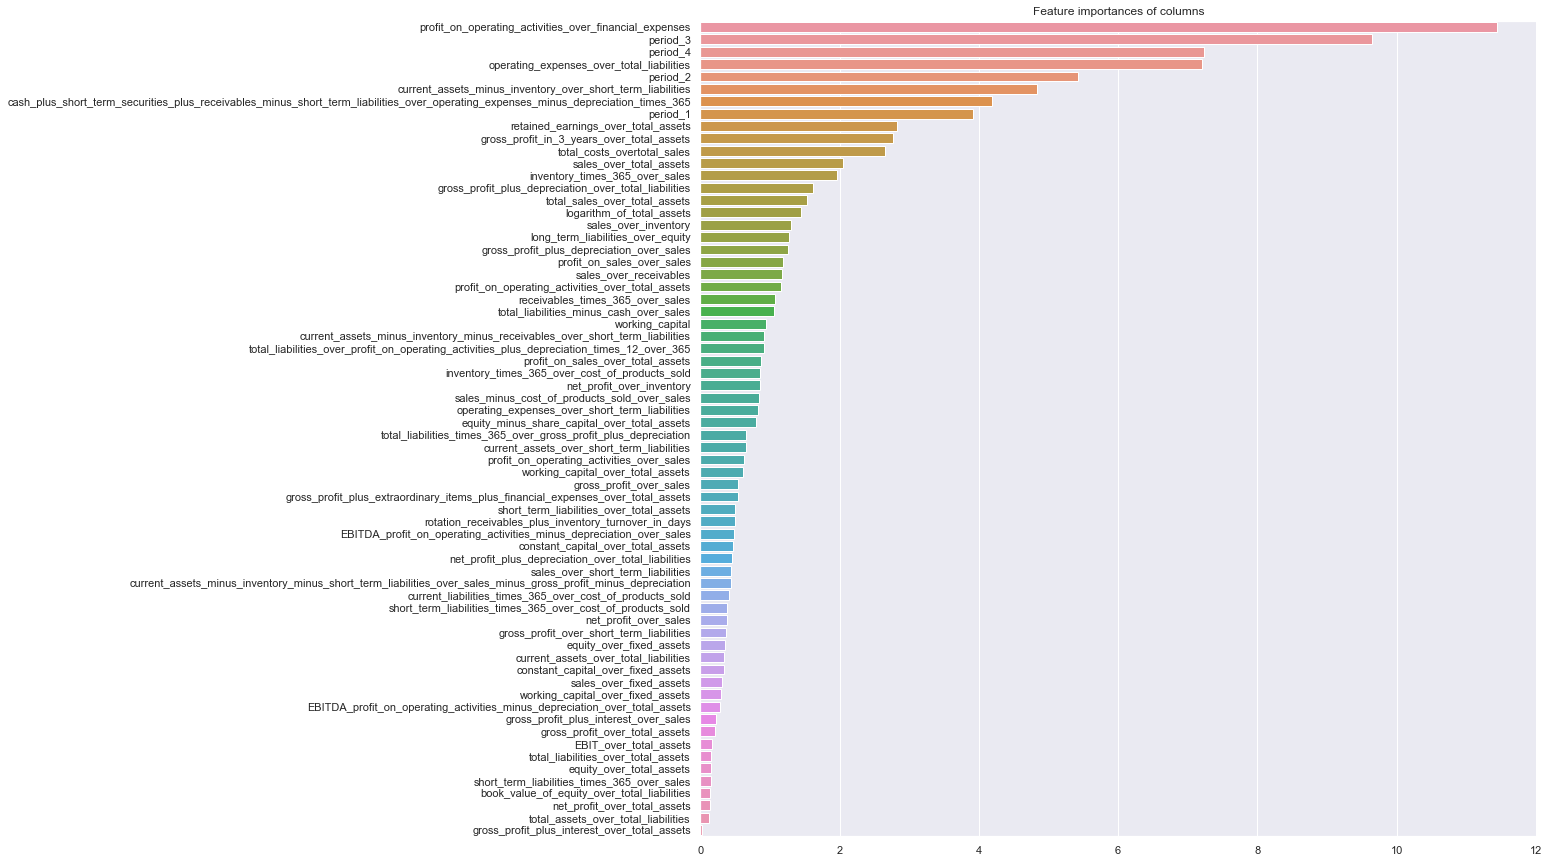

In [93]:
plt.figure(figsize=(15,15))
plt.title('Feature importances of columns')
sns.set_theme(style="darkgrid")
sns.barplot(imp_sorted, imp_sorted.index)
plt.show()

As the plot showed, diffrences between importances of columns are very large. Let's check which features have importance above value 0.5.

In [94]:
cols_not_to_drop = imp_df.where(imp_df > 0.5).dropna()
cols_not_to_drop_sorted = cols_not_to_drop.sort_values(ascending=False)

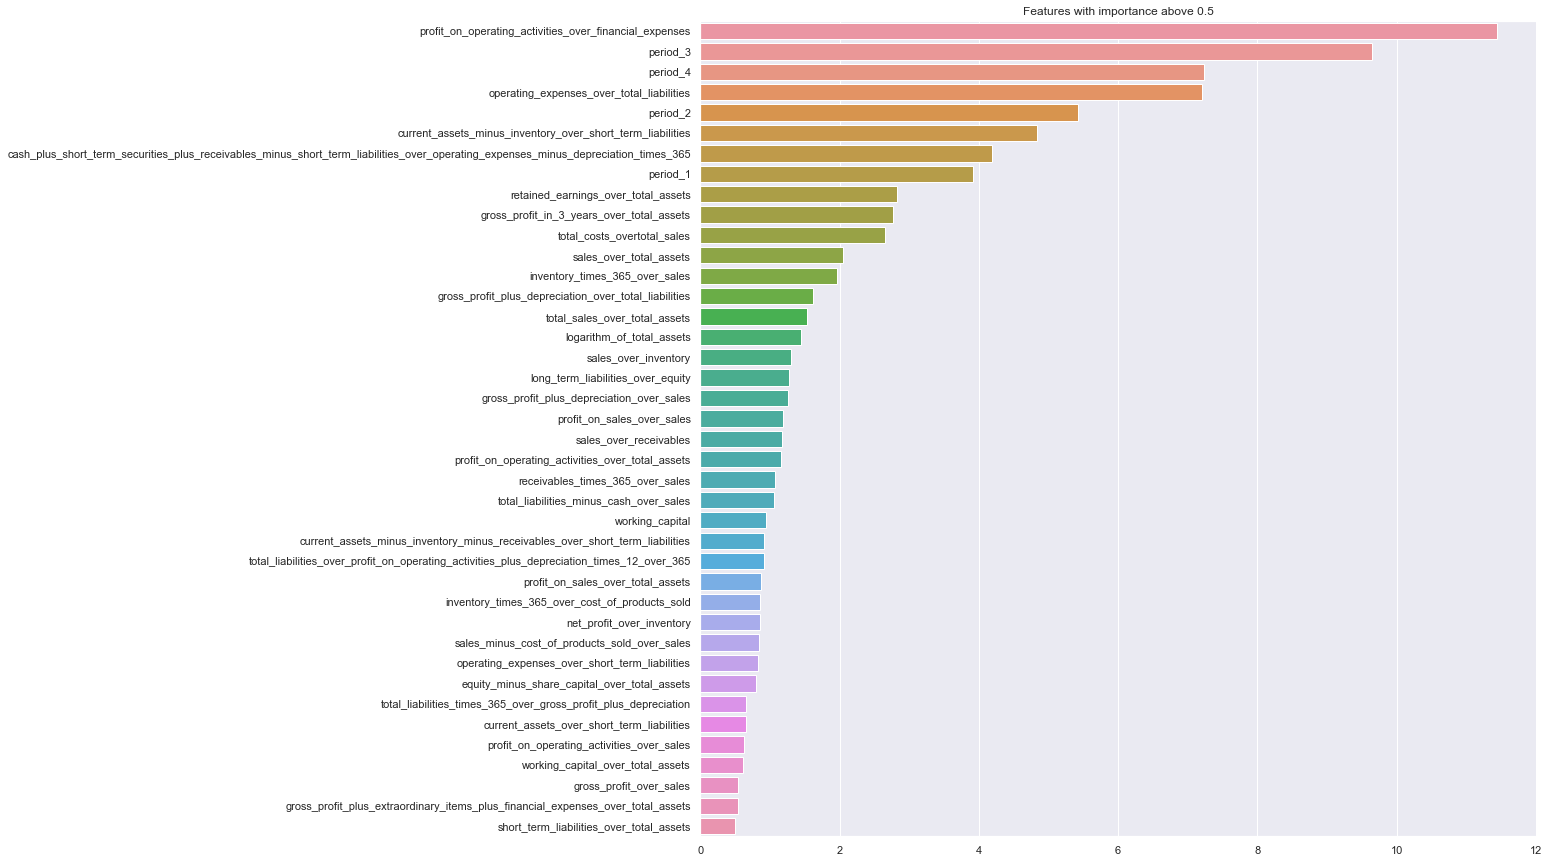

In [95]:
plt.figure(figsize=(15,15))
plt.title('Features with importance above 0.5')
sns.set_theme(style="darkgrid")
sns.barplot(cols_not_to_drop_sorted, cols_not_to_drop_sorted.index)
plt.show()

In [96]:
cols_not_to_drop.shape

(40,)

As it can be seen there are just 40 features with importance above 0.5. Let's drop those columns which have importance less than this value:

In [97]:
all_columns = X_train.columns 

In [98]:
cols_to_drop = all_columns.drop(cols_not_to_drop[4:].index)[1:] # selecting columns for dropping

In [99]:
X_new = X.drop(cols_to_drop, axis=1) # new X with dropped columns

In [100]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.3, random_state=42, 
                                                                    stratify=y, shuffle=True) # splitting new dataset

In [101]:
X_new_train = X_new_train.to_numpy() # to work with ColumnTransformer
X_new_test = X_new_test.to_numpy()
y_new_train = y_new_train.to_numpy()
y_new_test = y_new_test.to_numpy()

Let's define new Column Tranformer and Pipeline:

In [102]:
cat_ct_new = ColumnTransformer(transformers =[('oh', OneHotEncoder(), [0]), ('pt', pt, list(range(1, X_new.shape[1])))])

In [103]:
cat_new_pipe = Pipeline(steps=[('im', imputer), ('ct', cat_ct_new), ('adasyn', adasyn_cat), ('cat', cat_best)])

In [104]:
cat_new_pipe.fit(X_new_train, y_new_train, cat__early_stopping_rounds=10) # early stopping in 10 iterations
y_cat_new_pred = cat_new_pipe.predict(X_new_test)
f1_cat_new = f1_score(y_new_test, y_cat_new_pred)
print('F1 score for most important features: ' + str(f1_cat_new.round(4)))

F1 score for most important features: 0.7118


Selecting feature importances do not improve score for this model. This method will be not used later.

### 9. Finding best treshold

This section is dedicated for finding best treshold for modeling. With diffrent propability treshold value score can be improved. 

In [105]:
treshold = np.linspace(0, 1, 100).round(2) # 100 tresholds between 0 and 1

In [106]:
tre_dict = {} # for f1 score
prec_dict = {} # for precision score
rec_dict = {} # for recall score
cat_best_pipe.fit(X_train_np, y_train_np)
for num in treshold:
    y_pred_tre = (cat_best_pipe.predict_proba(X_test)[:,1] >= num).astype(int)
    f1_cat_tre = f1_score(y_test_np, y_pred_tre)
    prec_tre = precision_score(y_test_np, y_pred_tre)
    rec_tre = recall_score(y_test_np, y_pred_tre)
    tre_dict[num] = f1_cat_tre.round(4)
    prec_dict[num] = prec_tre.round(4)
    rec_dict[num] = rec_tre.round(4)

In [107]:
tre_df = pd.Series(tre_dict) # to work with plots 

In [108]:
tre_best =  tre_df.sort_values(ascending=False).head() # to show best scores

Let's look at th plot how f1 score is changing during treshold value growing:

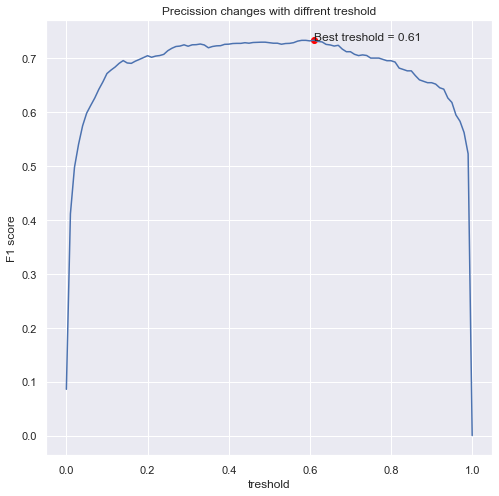

In [109]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tre_best.index[0], tre_best.values[0], c='red')
ax.plot(tre_df.index, tre_df.values)
ax.annotate(f'Best treshold = {tre_best.index[0]}', (tre_best.index[0], tre_best.values[0]))
ax.set_xlabel('treshold')
ax.set_ylabel('F1 score')
ax.set_title('Precission changes with diffrent treshold')
plt.show()

In [110]:
tre_best.head(1)

0.61    0.7338
dtype: float64

Best treshold for this model according f1 score is 0.61. This value improves score to 73.33 %. It's the best result achieved in this project.

### 10. Final thoughts about best model

First look at precision and recall changes during reshold growing:

In [111]:
prec_df = pd.Series(prec_dict)

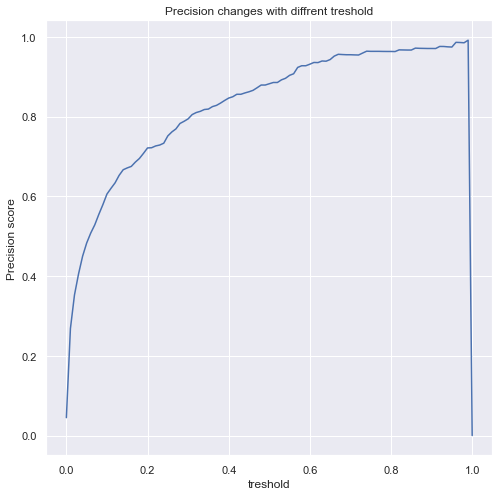

In [112]:
plt.figure(figsize=[8, 8])
plt.title('Precision changes with diffrent treshold')
plt.xlabel('treshold')
plt.ylabel('Precision score')
plt.plot(prec_df.index, prec_df.values)
plt.show()

As it can be seen precision score is growing with treshold.

In [113]:
rec_df = pd.Series(rec_dict)

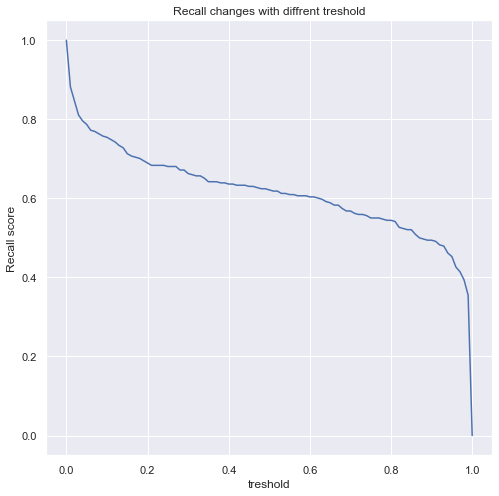

In [114]:
plt.figure(figsize=[8, 8])
plt.title('Recall changes with diffrent treshold')
plt.xlabel('treshold')
plt.ylabel('Recall score')
plt.plot(rec_df.index, rec_df.values)
plt.show()

Another thing is happened with recall. When treshold is rising, recall is falling down. So using diffrent tresholds in this model should depends from what is important for decidents, which are using model to make buisness decisions. 

Let's look for another metrics for best model, with treshold which is giving best f-1 score:

In [115]:
cat_best_pipe.fit(X_train_np, y_train_np)
y_pred_tre = (cat_best_pipe.predict_proba(X_test)[:,1] >= 0.61).astype(int)

In [116]:
print(classification_report(y_test_np, y_pred_tre))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7199
           1       0.94      0.60      0.73       338

    accuracy                           0.98      7537
   macro avg       0.96      0.80      0.86      7537
weighted avg       0.98      0.98      0.98      7537



Best model gives precission with 94 % score. It is very good result. It means that 94 % of predictions were predicted propely for class '1'. 

But worrying value is recall score. Score 60% means that model predicted just 60 % of bancrupted companies. It is not good result. Better result can be achieved with changing treshold to less value, but than more predictions will be bad. As it was explained earlier everything depends from decidents.

Accuracy score 98% is really good result but it doesn't matter, because data are imbalanced.

Finaly take a look for confusion matrix:

In [117]:
cm = confusion_matrix(y_test_np, y_pred_tre)

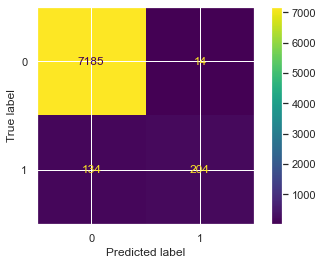

In [118]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=cat_best_pipe.classes_)
disp.plot()
plt.show()

As confusion matrix is showing 204 from 338 bancrupted companies were predicted propely, but 134 were not.

Another issue is that just 14 companies were predicted badly as companies that will bancrupt, but they did not. Both of these values show strenghts and weaknesses of the model.

### 11. Conclusion

According modeling steps, results was:

| Model | F-1 Score |
| --- | --- |
| mean impute + CatBoostClassifier | 0.6602 |
| mean impute + XGBClassifier | 0.6301 |
| mean impute + BaggingClassifier | 0.5135 |
| mean impute + CatBoostClassifier + PowerTransformer| 0.6744 |
| mean impute + XGBClassifier + MinMaxScaler| 0.6486 |
| mean impute + BaggingClassifier + PowerTransformer | 0.5391 |
| mean impute + CatBoostClassifier + PowerTransformer + ADASYN | 0.7133 |
| mean impute + CatBoostClassifier + PowerTransformer + ADASYN + sampling strategy | 0.7204 |
| mean impute + XGBClassifier + MinMaxScaler + ADASYN | 0.6606 |
| mean impute + XGBClassifier + MinMaxScaler +ADASYN + sampling stretegy | 0.6765 |
| mean impute + CatBoostClassifier + ADASYN + sampling strategy + hyperparameter tunning| 0.7314 |
| mean impute + CatBoostClassifier + ADASYN + sampling strategy + hyperparameter tunning + early stopping| 0.7213 |
| mean impute + XGBClasssifier + MinMaxScaler +ADASYN + sampling strategy + hyperparameter tunning| 0.7009 |
| mean impute + XGBClasssifier + MinMaxScaler + ADASYN + sampling strategy + hyperparameter tunning + early stopping| 0.7044 |
| mean impute + CatBoostClassifier + PowerTransformer +ADASYN + sampling strategy + hyperparameter tunning + feature importances| 0.7118 |
| **mean impute + CatBoostClassifier + PowerTransformer +ADASYN + sampling strategy + hyperparameter tunning + treshold** | **0.7338** |

As it can be seen in the table some of methods improved score, some of them not. Result 73.38 % is still not good result. As it was explained in previous chapter weakness of this model is bad recall score, what means that model will not find companies that will bankrupt. But there are some issues that in future can improve model, or choose better one:

- more column transformations
- getting feature importances before modeling, maybe by using diffrent model (for example XGBClassifier can choose feature importances by weight)
- using PCA
- using diffrent models (for example Keras Models, GradientBoostingClassifier, or LGBMClassifier)
- imput more hyperparameters for GridSearchCV
- diffrently normalize columns

All of those methods can improve score. For now I'll keep score 73.38 %, as a first score at self made project :)